# 🏘️ California Housing 🏘️

Este proyecto se centra en el análisis y la predicción de precios de viviendas en el estado de California utilizando un dataset que contiene información detallada sobre 20,640 bloques residenciales. Cada fila en el dataset representa un bloque, que es una pequeña área geográfica delimitada por calles y que contiene un grupo de viviendas. Las variables incluidas en el dataset abarcan aspectos geográficos, demográficos y económicos que influyen en el mercado inmobiliario. En particular, se tienen en cuenta la longitud y latitud de las propiedades para analizar su ubicación relativa, la antigüedad media de las viviendas en cada bloque, el número total de habitaciones y dormitorios, así como la población y el número de hogares en cada bloque. Además, el dataset incluye datos sobre el ingreso medio de los hogares y el valor medio de las viviendas, medidos en dólares estadounidenses, así como la proximidad al océano, una característica que puede tener un impacto significativo en los valores de las propiedades.

El objetivo principal de este proyecto es identificar los factores clave que determinan los precios de las viviendas en California y desarrollar un modelo de machine learning capaz de predecir el valor de una casa en función de estas características. Este análisis no solo proporcionará una comprensión más profunda de las dinámicas del mercado inmobiliario en California, sino que también permitirá evaluar la relación entre la ubicación, las características estructurales, y las condiciones socioeconómicas en los precios de las viviendas. Los resultados obtenidos a partir de este estudio podrán ser aplicados en la valoración de propiedades, la planificación urbana y en la toma de decisiones tanto para compradores como para vendedores de bienes raíces.

Descripcion de columnas:

-latitude: latitud de la ubicacion del bloque.

-longitude: longitud de la ubicacion del bloque.

-housing_median_age: mediana de edad de las propiedades en el bloque.

-total_rooms: habitaciones totales en el bloque.

-total_bedrooms: dormitorios totales en el bloque.

-population: cantidad de habitantes en el bloque.

-households: cantidad de hogares en el bloque.

-median_income: mediana de ingresos en el bloque.

-median_house_value: mediana de valor de las propiedades en el bloque

-ocean_proximity: proximidad al oceano del bloque

## 📚 Importación de librerias 📚

In [124]:
# importo las librerias que voy a usar
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import xgboost as xgb
import itertools
from seaborn import histplot
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn import metrics
from xgboost import XGBRegressor, plot_importance
from mpl_toolkits.mplot3d import Axes3D
from lazypredict.Supervised import LazyRegressor

## 🔗 Importación de la Base de Datos 🔗

In [3]:
# Importo la base de datos csv de mi Github (fue obtenida en Kaggle)
url = "https://raw.githubusercontent.com/djender985/CursoDataScience-II/refs/heads/main/Proyecto/housing.csv"
df = pd.read_csv(url, sep=',')

## 🔍 Data Wrangling y EDA 🔎🔬💊

### 🔍 Inspección inicial de datos 🔎

In [4]:
# para conocer la forma del dataset
print("\n")
print('\n\nThe shape of this dataset is:', {df.shape})
print("\n")

# Observo los datos
df.head(5)





The shape of this dataset is: {(20640, 10)}




longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.50     37.79                  52            8             1.0   
1    -116.95     33.86                   1            6             2.0   
2    -117.79     35.21                   4            2             2.0   
3    -119.54     36.51                  36           49             7.0   
4    -116.76     34.14                   4           42            10.0   

   population  households  median_income  median_house_value ocean_proximity  
0          13           1        15.0001              500001        NEAR BAY  
1           8           2         1.6250               55000          INLAND  
2           6           2         2.3750              137500          INLAND  
3          28           2         4.6250              162500          INLAND  
4           9           3         0.5360               42500          INLAND

In [5]:
# Quiero ver el tipo de datos de cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


### 🔬 Una inspección minuciosa 🔬

In [6]:
# Reviso si hay algun valor nulo en el dataframe
df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [7]:
# Tambien, si quiero verificar la cantidad de valores nulos en las columnas
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

####
Hay 207 filas donde 'total_bedrooms' es nulo. Quiero indagar como lucen esas filas para tomar una decisión al respecto.

In [8]:
# Comprobamos si existen duplicados
df[df.duplicated()].sort_values(by="median_house_value")

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity]
Index: []

No existen duplicados

In [9]:
# Defino un nuevo dataframe con las filas donde 'total_bedrooms' es nulo
nulos_total_bedrooms = df[df['total_bedrooms'].isnull()]

In [10]:
# Visualizo 5 filas del DataFrame con nulos en 'total_bedrooms'
nulos_total_bedrooms.sample(5).style.map(
        lambda x: 'color: red; font-weight: bold;', 
    subset=['total_bedrooms']
)

##### LLegué a la conclusión de que estos son datos erróneos ya que un hogar que tenga más de 1 habitación es imposible que no tenga dormitorios. He decidido sacar del DataFrame estos datos.

In [11]:
# Saco del dataset esas filas
df = df.dropna(subset=['total_bedrooms'])

print('\nEl numero total de filas luego de la limpieza es de', len(df))


El numero total de filas luego de la limpieza es de 20433


### 🛠️ Data Transformation 🛠️

In [12]:
# Crear la columna para el promedio de habitaciones por hogar
df['avg_rooms_per_household'] = df['total_rooms'] / df['households']

# Crear la columna para el promedio de dormitorios por hogar
df['avg_bedrooms_per_household'] = df['total_bedrooms'] / df['households']


In [13]:
df.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.50     37.79                  52            8             1.0   
1    -116.95     33.86                   1            6             2.0   
2    -117.79     35.21                   4            2             2.0   
3    -119.54     36.51                  36           49             7.0   
4    -116.76     34.14                   4           42            10.0   
5    -114.62     33.62                  26           18             3.0   
6    -122.37     37.60                  26           15             3.0   
7    -117.12     32.66                  52           16             4.0   
8    -118.44     34.04                  16           18             6.0   
9    -118.43     33.97                  16           70             7.0   

   population  households  median_income  median_house_value ocean_proximity  \
0          13           1        15.0001              500001        NEAR BAY   
1           8           2         1.6250               55000          INLAND   
2           6           2         2.3750              137500          INLAND   
3          28           2         4.6250              162500          INLAND   
4           9           3         0.5360               42500          INLAND   
5           5           3         0.5360              275000          INLAND   
6          11           3         5.0480              350000      NEAR OCEAN   
7           8           3         1.1250               60000      NEAR OCEAN   
8           3           4         0.5360              350000       <1H OCEAN   
9          17           4         7.7197              500001       <1H OCEAN   

   avg_rooms_per_household  avg_bedrooms_per_household  
0                 8.000000                    1.000000  
1                 3.000000                    1.000000  
2                 1.000000                    1.000000  
3                24.500000                    3.500000  
4                14.000000                    3.333333  
5                 6.000000                    1.000000  
6                 5.000000                    1.000000  
7                 5.333333                    1.333333  
8                 4.500000                    1.500000  
9                17.500000                    1.750000

In [14]:
# Quiero visualizar maximos y minimos
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20433.000000  20433.000000        20433.000000  20433.000000   
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348           12.591805   2185.269567   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.720000           37.000000   3143.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20433.000000  20433.000000   20433.000000   
mean       537.870553   1424.946949    499.433465       3.871162   
std        421.385070   1133.208490    382.299226       1.899291   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563700   
50%        435.000000   1166.000000    409.000000       3.536500   
75%        647.000000   1722.000000    604.000000       4.744000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  avg_rooms_per_household  avg_bedrooms_per_household  
count        20433.000000             20433.000000                20433.000000  
mean        206864.413155                 5.431344                    1.097062  
std         115435.667099                 2.482946                    0.476104  
min          14999.000000                 0.846154                    0.333333  
25%         119500.000000                 4.441441                    1.006029  
50%         179700.000000                 5.230769                    1.048889  
75%         264700.000000                 6.052381                    1.099631  
max         500001.000000               141.909091                   34.066667

####
Me llama la atención el máximo de promedio de habitaciones por hogar. Quiero ver como  es la distribución de esa columna. Uso un histograma.

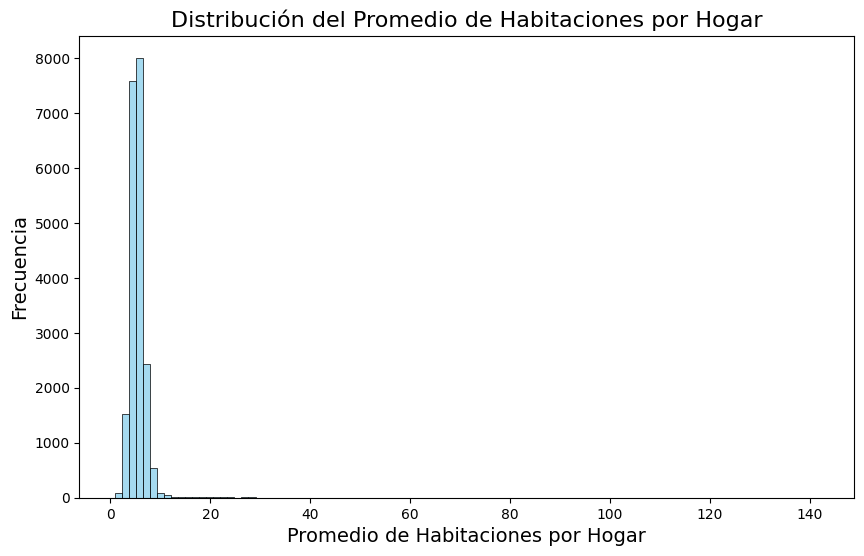

In [15]:

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_rooms_per_household'], bins=100, color='skyblue')

# Añadir títulos y etiquetas
plt.title('Distribución del Promedio de Habitaciones por Hogar', fontsize=16)
plt.xlabel('Promedio de Habitaciones por Hogar', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()

####
No se aprecia pero hay valores bastante altos en los promedios que tienen muy baja frecuencia (tan baja que no se aprecia en el grafico).
Voy a probar de visualizar estos valores de otra forma que pueda apreciar mejor.

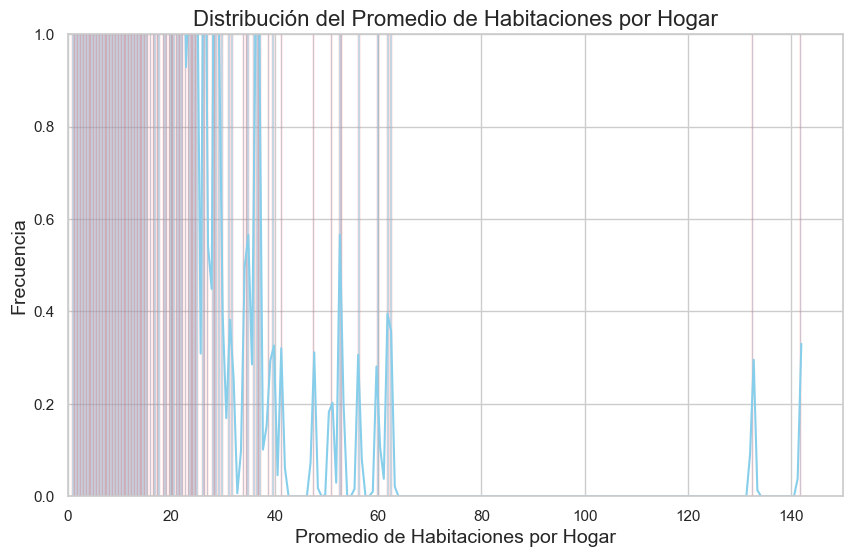

In [16]:
# Primero voy a visualizar el histograma anterior de una mejor manera
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_rooms_per_household'], bins=500, kde=True, color='skyblue', edgecolor='red')

# Limitar el eje X hasta 6
plt.xlim(0, 150)
plt.ylim(0, 1)

# Añadir títulos y etiquetas
plt.title('Distribución del Promedio de Habitaciones por Hogar', fontsize=16)
plt.xlabel('Promedio de Habitaciones por Hogar', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()


Observamos que hay outliers que no tienen sentido. Podrian ser real pero no representa lo que ocurre en la mayoria de registros y como me distorsiona el dataframe, he decidido removerlos.

### 🔴🔴🟢🟢🟢 Detección y análisis exhaustivo de Outliers 🟢🟢🟢🔴🔴

#### 🔷 Enfoque IQR 🔷

In [17]:
# Remuevo los outliers de la columna avg_rooms_per_household

# Calcular Q1 (percentil 25) y Q3 (percentil 75) para avg_rooms_per_household
Q1 = df['avg_rooms_per_household'].quantile(0.25)
Q3 = df['avg_rooms_per_household'].quantile(0.75)

# Calcular IQR
IQR = Q3 - Q1

# Calcular los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame eliminando los outliers
df_sin_outliers_1 = df[(df['avg_rooms_per_household'] >= lower_bound) & 
        (df['avg_rooms_per_household'] <= upper_bound)]

# Confirmar la eliminación de outliers
print(f'Número de filas después de eliminar outliers: {df_sin_outliers_1.shape[0]}')
print(f'Total de filas outliers eliminadas: {df.shape[0] - df_sin_outliers_1.shape[0]}')



Número de filas después de eliminar outliers: 19925
Total de filas outliers eliminadas: 508


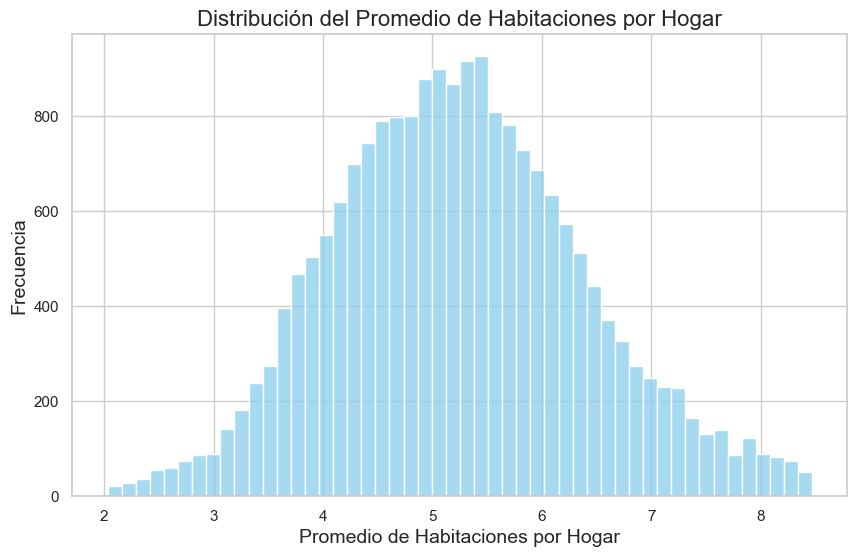

In [18]:
# Ahora vemos como luce el histograma nuevamente ahora que quitamos los outliers de avg_rooms_per_household

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_sin_outliers_1['avg_rooms_per_household'], bins=50, color='skyblue')

# Añadir títulos y etiquetas
plt.title('Distribución del Promedio de Habitaciones por Hogar', fontsize=16)
plt.xlabel('Promedio de Habitaciones por Hogar', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()

Ahora parece mas una distribución normal

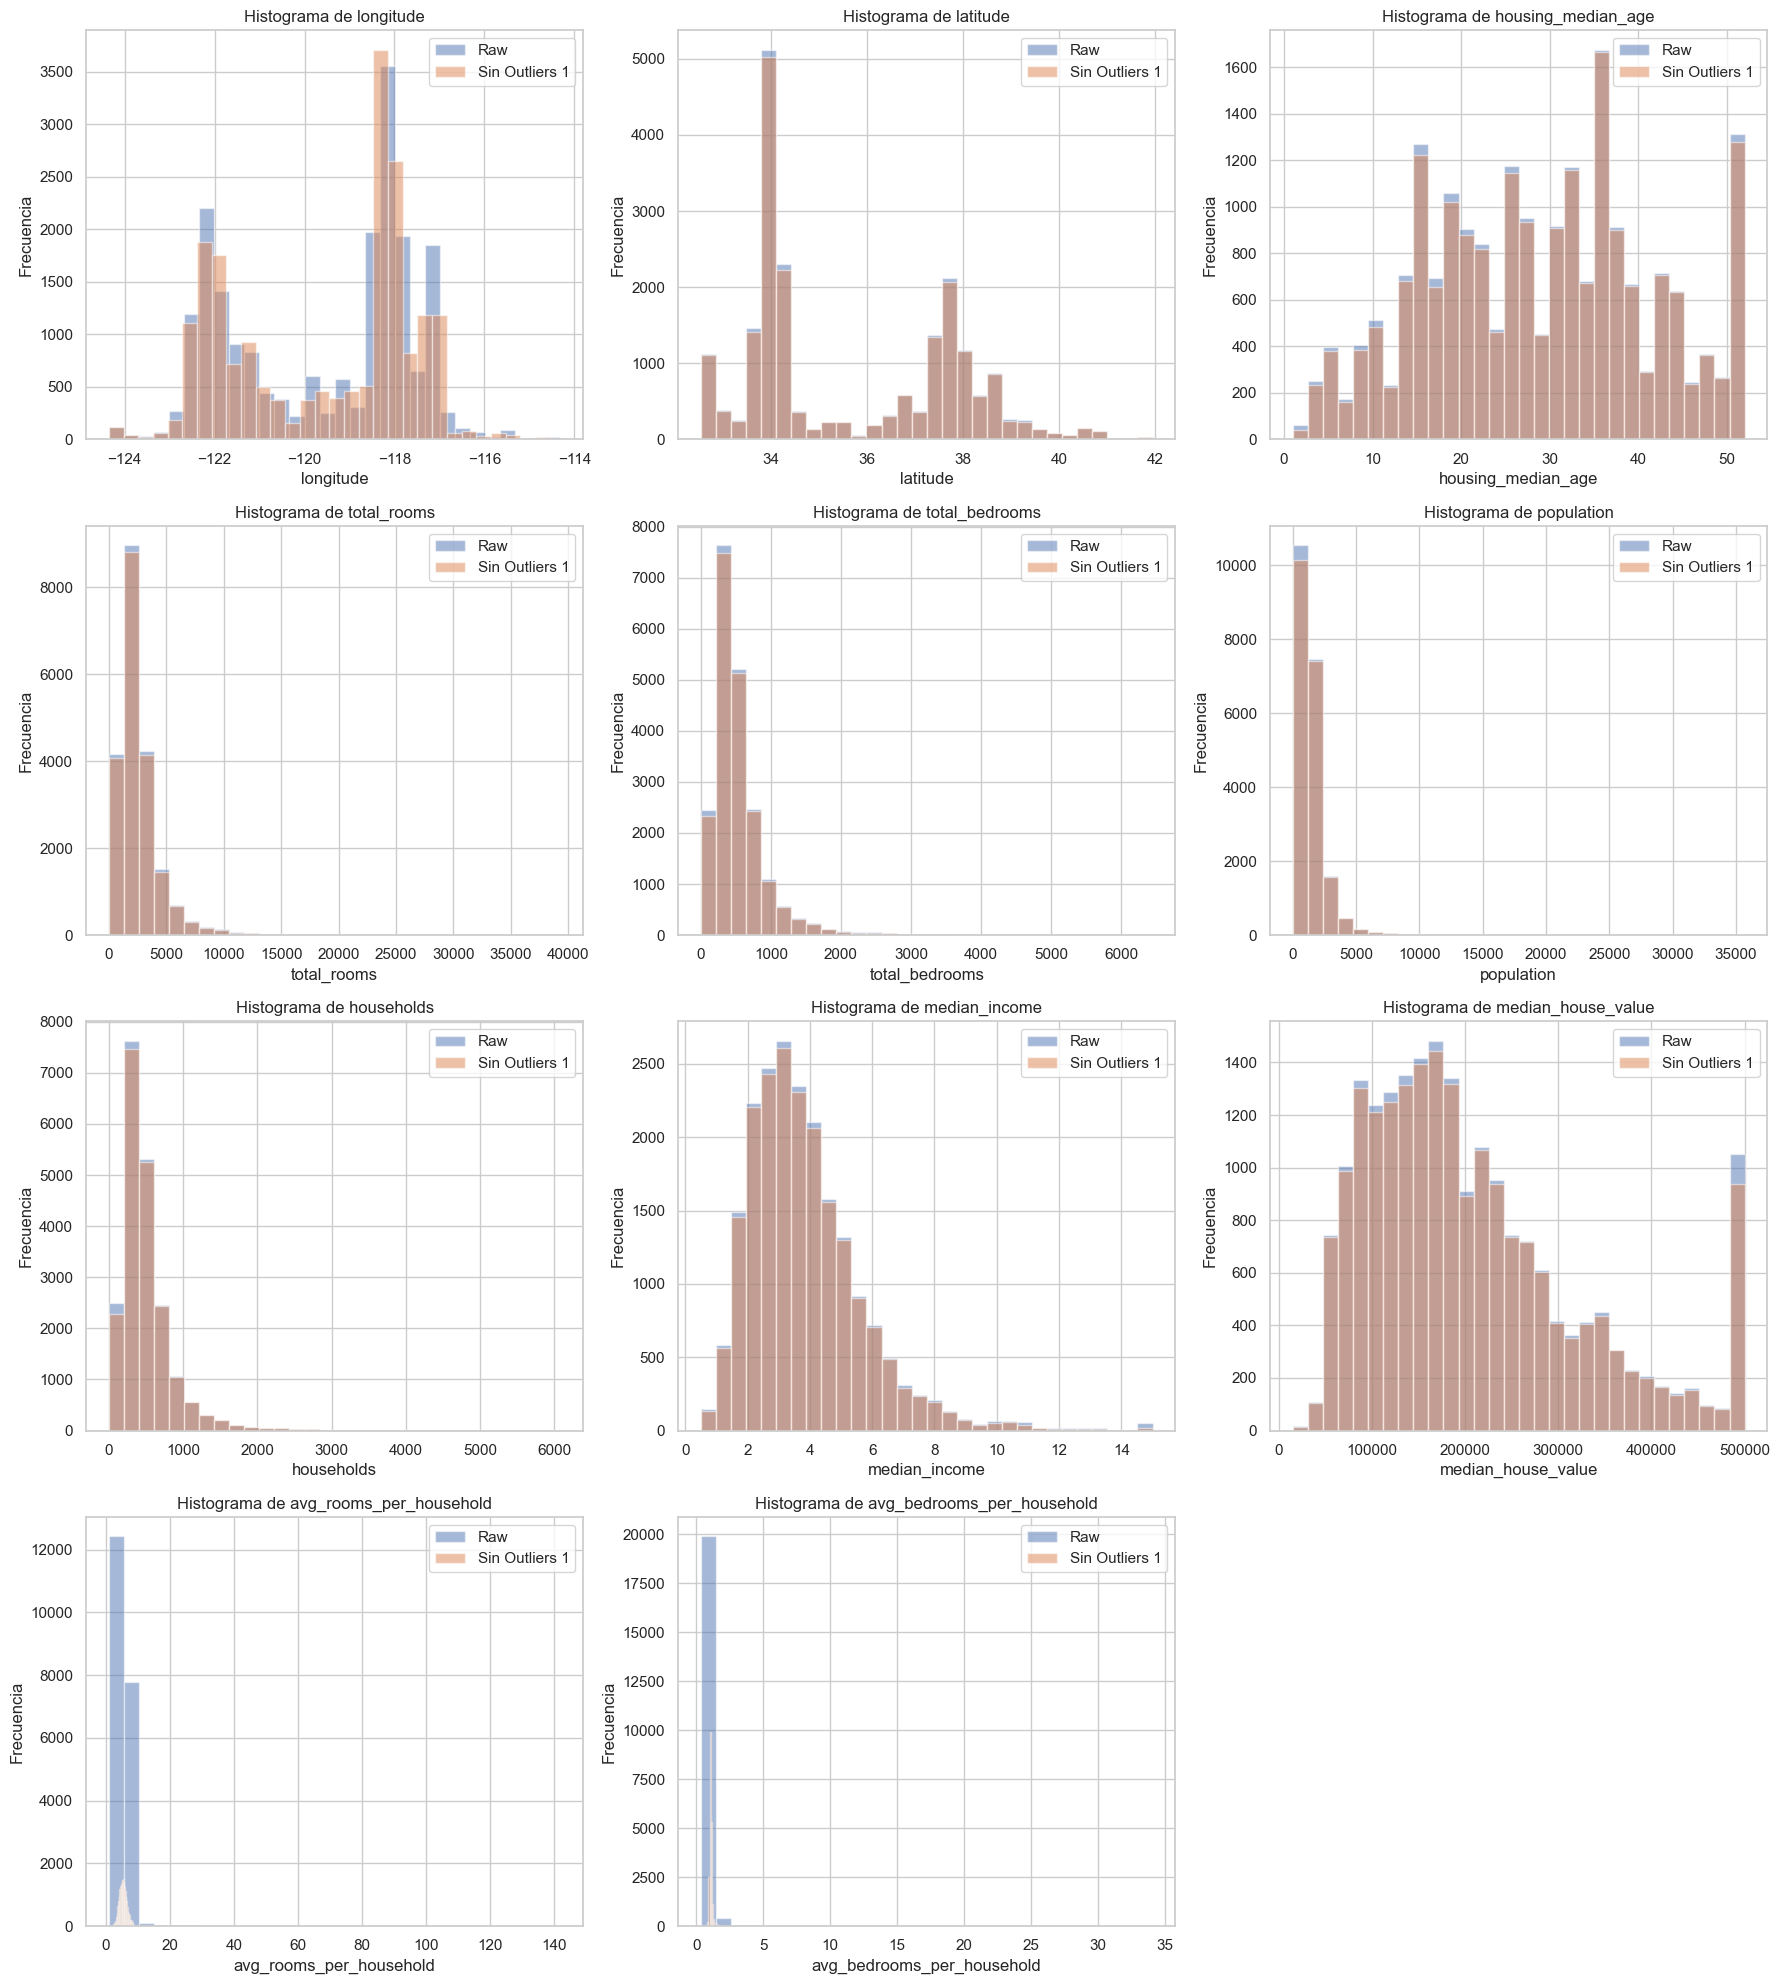

In [19]:
# Hacemos una comparativa de histogramas luego de remover outliers

# Selección de columnas numéricas
num_cols = df_sin_outliers_1.select_dtypes(include=['number']).columns

# Configurar el número de columnas y filas
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Calcular filas necesarias

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()  # Convertir la matriz de ejes en una lista

for i, col in enumerate(num_cols):
    ax = axes[i]
    
    # Histogramas superpuestos
    ax.hist(df[col], bins=30, alpha=0.5, label='Raw')
    ax.hist(df_sin_outliers_1[col], bins=30, alpha=0.5, label='Sin Outliers 1')
    
    ax.set_title(f'Histograma de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.legend()

# Eliminar gráficos vacíos si hay menos columnas que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Dado que el enfoque IQR es ideal en situaciones en la que los datos tienen distribuciones aproximadamente "normales", he decidido implementar un modelo mas acorde a la distribucion de mis datos.

#### 🤔💭 Analisis previo a la detección de outliers por Isolation Forest 🤔💭

He llegado al siguiente analisis:

El valor de 500,001 probablemente representa un techo artificial impuesto en el dataset, lo que podría responder a restricciones legales, políticas de privacidad, o simplemente un límite de muestreo.

Si realmente es un límite superior, esos registros representan propiedades que superan los $500,000 pero no especifican en cuánto. Esto genera una pérdida de información porque se trata igual una propiedad de $600,000 que una de $2,000,000.

Incluir este bin puede sesgar el modelo, ya que el algoritmo podría interpretar que $500,001 es un valor exacto y no un indicador de "mayor a $500,000". Esto podría afectar negativamente la precisión del modelo para valores altos.

Excluirlos podria ser razonable pero estaria bueno afrontar esto con un enfoque híbrido, donde se tendrían que implementar 2 modelos; uno para variable numérica y otro para clasificación.

#### 🌳 Isolation Forest 🌲

In [20]:
# Primero voy a excluir las propiedades con valor mayor a 500.000
df2 = df[(df['median_house_value'] <= 500000)]

total = df.shape[0]
excluidos = df[df['median_house_value'] > 500000].shape[0]
print('\n')
print(f'Se han excluido {excluidos} registros de un total de {total}.')
print(f'Quedan {df2.shape[0]} registros.')
print('\n')


# Ahora voy a detectar outliers usando Isolation Forest

# Primero voy a pasar mi dimension categorica (Ocean Proximity) a numérica (discreta)
encoder = OrdinalEncoder(categories=[["INLAND", "<1H OCEAN", "NEAR OCEAN", "NEAR BAY", "ISLAND"]])

# Copio el df
df_encoded = df2.copy()

# Creo la columna encoded
df_encoded['ocean_proximity_encoded'] = encoder.fit_transform(df_encoded[['ocean_proximity']])

# Elimino la columna categorica
df_encoded = df_encoded.drop(columns=['ocean_proximity'])

# Defino el modelo y sus parámetros
isolation_forest = IsolationForest(n_estimators=500, contamination=0.10)

# Entreno el modelo con el dataframe encoded
isolation_forest.fit(df_encoded)

# Se guarda en otro df las predicciones
predictions = isolation_forest.predict(df_encoded)

# Incluyo esas predicciones al dataframe encoded en la nueva columna Anomaly
df_encoded['anomaly']=predictions

# Guardamos los outliers en un dataframe
outliers=df_encoded.loc[df_encoded['anomaly']==-1]

# Observemos los outliers antes de tomar una decisión
outliers



Se han excluido 958 registros de un total de 20433.
Quedan 19475 registros.




longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1        -116.95     33.86                   1            6             2.0   
2        -117.79     35.21                   4            2             2.0   
3        -119.54     36.51                  36           49             7.0   
4        -116.76     34.14                   4           42            10.0   
5        -114.62     33.62                  26           18             3.0   
...          ...       ...                 ...          ...             ...   
20634    -121.53     38.48                   5        27870          5027.0   
20636    -117.78     34.03                   8        32054          5290.0   
20637    -117.74     33.89                   4        37937          5471.0   
20638    -121.44     38.43                   3        39320          6210.0   
20639    -121.79     36.64                  11        32627          6445.0   

       population  households  median_income  median_house_value  \
1               8           2         1.6250               55000   
2               6           2         2.3750              137500   
3              28           2         4.6250              162500   
4               9           3         0.5360               42500   
5               5           3         0.5360              275000   
...           ...         ...            ...                 ...   
20634       11935        4855         4.8811              212200   
20636       15507        5050         6.0191              253900   
20637       16122        5189         7.4947              366300   
20638       16305        5358         4.9516              153700   
20639       28566        6082         2.3087              118800   

       avg_rooms_per_household  avg_bedrooms_per_household  \
1                     3.000000                    1.000000   
2                     1.000000                    1.000000   
3                    24.500000                    3.500000   
4                    14.000000                    3.333333   
5                     6.000000                    1.000000   
...                        ...                         ...   
20634                 5.740474                    1.035427   
20636                 6.347327                    1.047525   
20637                 7.311043                    1.054346   
20638                 7.338559                    1.159015   
20639                 5.364518                    1.059684   

       ocean_proximity_encoded  anomaly  
1                          0.0       -1  
2                          0.0       -1  
3                          0.0       -1  
4                          0.0       -1  
5                          0.0       -1  
...                        ...      ...  
20634                      0.0       -1  
20636                      1.0       -1  
20637                      1.0       -1  
20638                      0.0       -1  
20639                      1.0       -1  

[1948 rows x 13 columns]

Como observamos, con este modelo está detectando 1948 outliers correspondiente al 10% de contamination que seteamos.

Cabe destactar que usando el Isolation Forest se tienen en cuenta todas las columnas del dataframe.

In [21]:
# Quito los outliers del dataframe
df_sin_outliers_2=df_encoded.loc[df_encoded['anomaly'] != -1]

# Confirmar la eliminación de outliers
print('\n')
print(f'Número de filas después de eliminar outliers: {df_sin_outliers_2.shape[0]}')
print(f'Total de filas outliers eliminadas: {df.shape[0] - df_sin_outliers_2.shape[0]}')
print('\n')




Número de filas después de eliminar outliers: 17527
Total de filas outliers eliminadas: 2906




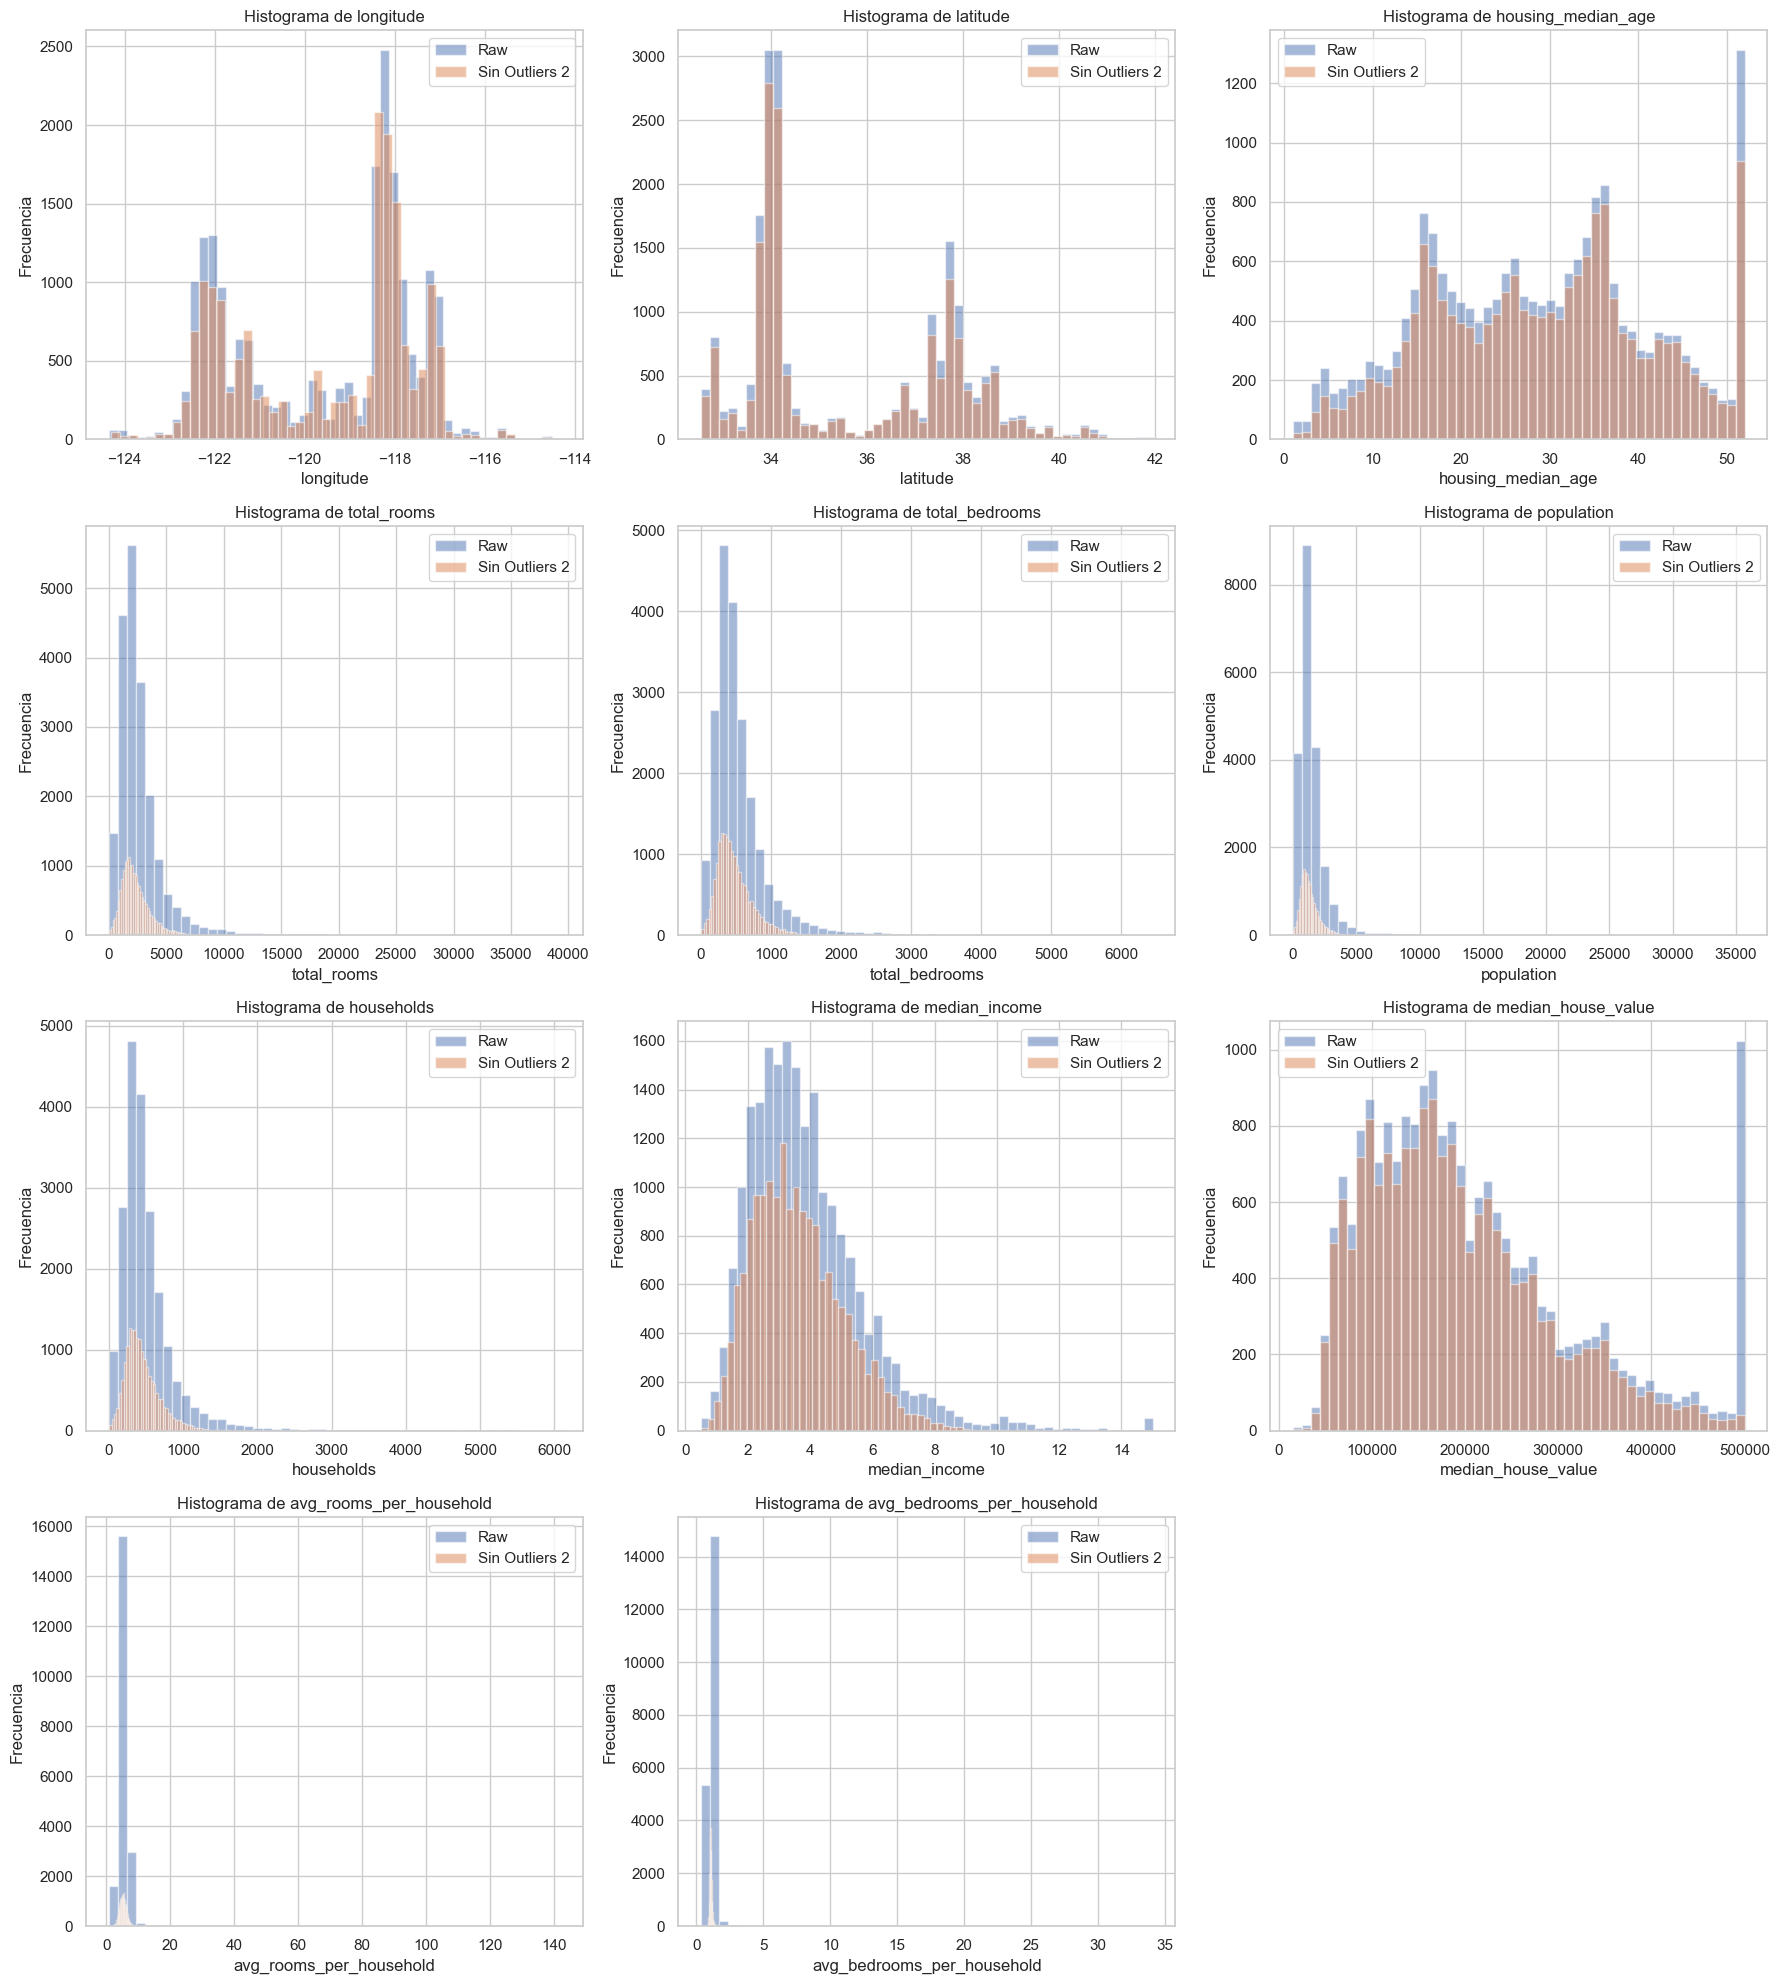

In [22]:
# Comparamos con lo que teniamos originalmente

# Tengo que eliminar las columnas de encoder y anomaly sin modificar el df ya que mas adelante si me van a servir esas columnas
df_sin_outliers_2_copy = df_sin_outliers_2.drop(columns = ['ocean_proximity_encoded', 'anomaly'])


# Selección de columnas numéricas
num_cols = df_sin_outliers_2_copy.select_dtypes(include=['number']).columns

# Configurar el número de columnas y filas
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Calcular filas necesarias

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()  # Convertir la matriz de ejes en una lista

for i, col in enumerate(num_cols):
    ax = axes[i]
    
    # Histogramas superpuestos
    ax.hist(df[col], bins=50, alpha=0.5, label='Raw')
    ax.hist(df_sin_outliers_2_copy[col], bins=50, alpha=0.5, label='Sin Outliers 2')
    
    ax.set_title(f'Histograma de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.legend()

# Eliminar gráficos vacíos si hay menos columnas que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 🥽 Analisis univariado 🥽

In [23]:
# Guardo este dataframe como definitivo luego de la limpieza de outliers
df2 = df_sin_outliers_2.drop(columns = ['anomaly','ocean_proximity_encoded'])
df2.sample(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
18041    -118.45     35.58                  16         5396          1182.0   
19215    -118.52     34.22                  21         4617          1101.0   
16958    -121.63     36.68                  24         2591           739.0   
5768     -119.85     36.77                  27         1510           344.0   
3736     -117.91     33.83                  37         1039           260.0   
17196    -121.87     37.42                  25         4430           729.0   
13531    -122.40     37.80                  52         1642           570.0   
13429    -121.42     38.72                  10         3054           528.0   
15160    -118.26     34.07                  52         1802           613.0   
15257    -118.36     33.96                  37         2146           573.0   

       population  households  median_income  median_house_value  \
18041        1802         807         1.8819               69700   
19215        2891        1031         3.2289              318100   
16958        3243         702         2.1766              108500   
5768          847         295         2.9315               83200   
3736          719         243         3.0288              161400   
17196        2685         721         5.6965              261100   
13531        1432         513         1.9063              300000   
13429        1932         510         3.0903               91900   
15160        2382         587         1.8438              185900   
15257        2009         592         3.6583              177300   

       avg_rooms_per_household  avg_bedrooms_per_household  
18041                 6.686493                    1.464684  
19215                 4.478177                    1.067895  
16958                 3.690883                    1.052707  
5768                  5.118644                    1.166102  
3736                  4.275720                    1.069959  
17196                 6.144244                    1.011096  
13531                 3.200780                    1.111111  
13429                 5.988235                    1.035294  
15160                 3.069847                    1.044293  
15257                 3.625000                    0.967905

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>],
       [<Axes: title={'center': 'avg_rooms_per_household'}>,
        <Axes: title={'center': 'avg_bedrooms_per_household'}>, <Axes: >]],
      dtype=object)

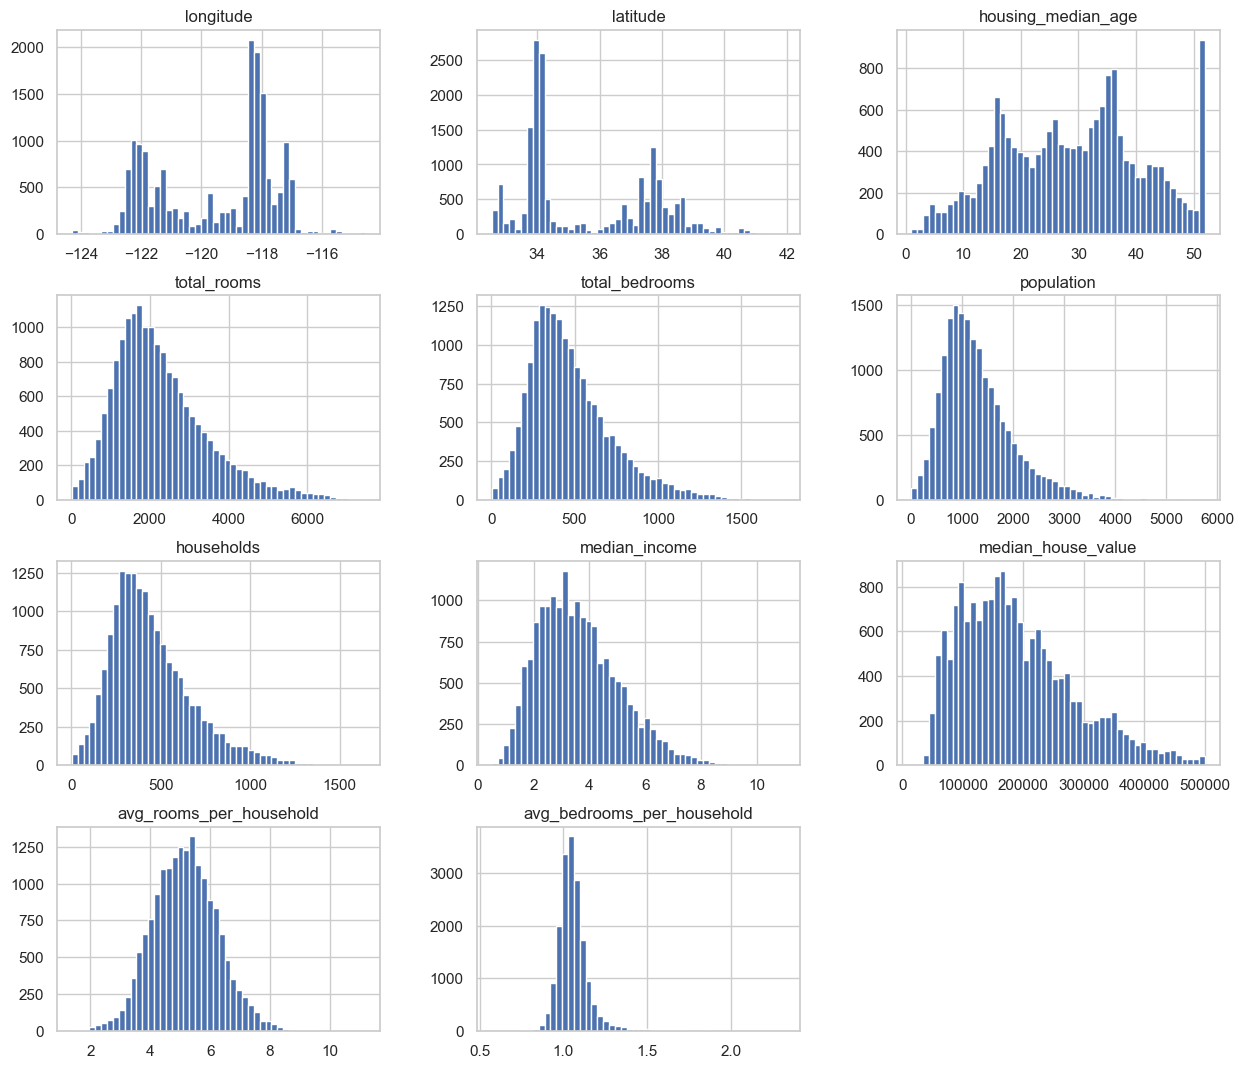

In [24]:
df2.hist(figsize= (15,13), bins= 50)

In [25]:
df2.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'avg_rooms_per_household',
       'avg_bedrooms_per_household'],
      dtype='object')

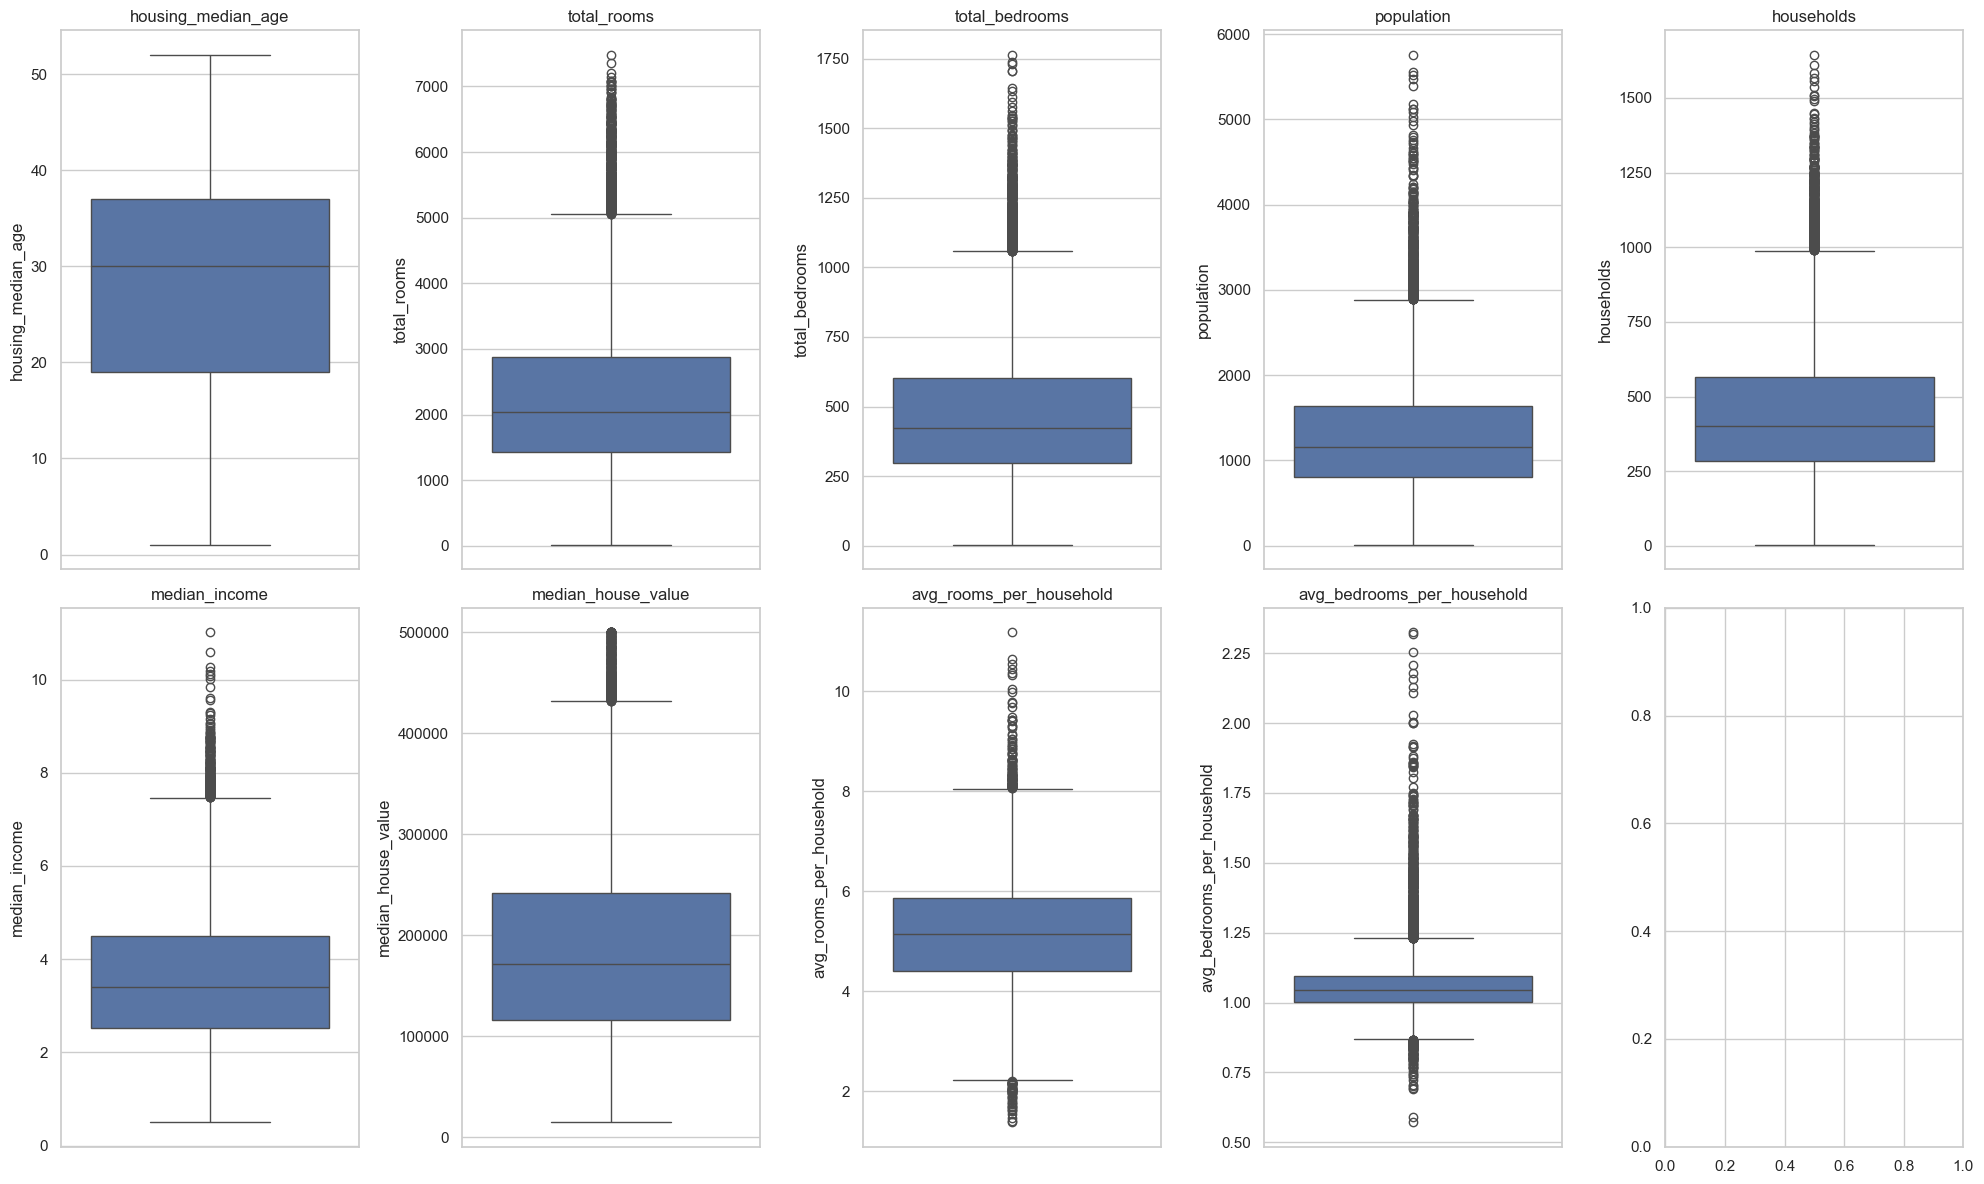

In [26]:
# Lista de variables para graficar
variables = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
             'median_income', 'median_house_value', 'avg_rooms_per_household', 'avg_bedrooms_per_household']

# Configurar la figura
fig, axes = plt.subplots(2, len(variables)//2 + len(variables)%2, figsize=(20, 12))  # Dividir en 2 filas
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

# Crear un boxplot para cada variable
for ax, variable in zip(axes, variables):
    sns.boxplot(y=variable, data=df2, ax=ax)
    ax.set_title(variable)

# Ajustar diseño
plt.tight_layout()
plt.show()

No removeré otros outliers ya que creo que son datos que no estan lejos de la realidad.
Las columnas total_rooms y total_bedrooms es probable que ya no se necesiten. Sin embargo, no las voy a desestimar todavía.

Para saber que porcentaje representan las casas cerca de la bahia u oceano, hacemos un grafico de torta

In [27]:
# Traigo de vuelta la columna ocean_proximity
df2['ocean_proximity'] = df.loc[df2.index, 'ocean_proximity']


In [28]:
df2.sample(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1219     -121.42     37.74                  45          818           144.0   
6719     -122.00     37.40                  35         1542           298.0   
18615    -121.28     38.71                   8         4053           912.0   
11433    -118.15     34.16                  38         2471           529.0   
9794     -118.85     35.23                  26         1639           352.0   
16312    -118.26     34.12                  45         2839           698.0   
13616    -121.30     38.25                  27         2475           548.0   
6256     -122.56     37.97                  52         1833           324.0   
1929     -117.85     34.08                  23         1160           166.0   
13071    -121.27     38.62                  13         2321           539.0   

       population  households  median_income  median_house_value  \
1219          340         138         4.8021              133500   
6719         1164         318         5.9145              236900   
18615        2033         897         2.8973              117100   
11433        1661         441         2.2765              146600   
9794         1222         395         1.7656               68000   
16312        1768         653         3.1306              214000   
13616        1703         517         2.5727               86100   
6256          735         306         4.6944              398900   
1929          467         178         8.1050              386200   
13071        1066         497         2.7652               95600   

       avg_rooms_per_household  avg_bedrooms_per_household ocean_proximity  
1219                  5.927536                    1.043478          INLAND  
6719                  4.849057                    0.937107       <1H OCEAN  
18615                 4.518395                    1.016722          INLAND  
11433                 5.603175                    1.199546       <1H OCEAN  
9794                  4.149367                    0.891139          INLAND  
16312                 4.347626                    1.068913       <1H OCEAN  
13616                 4.787234                    1.059961          INLAND  
6256                  5.990196                    1.058824        NEAR BAY  
1929                  6.516854                    0.932584       <1H OCEAN  
13071                 4.670020                    1.084507          INLAND

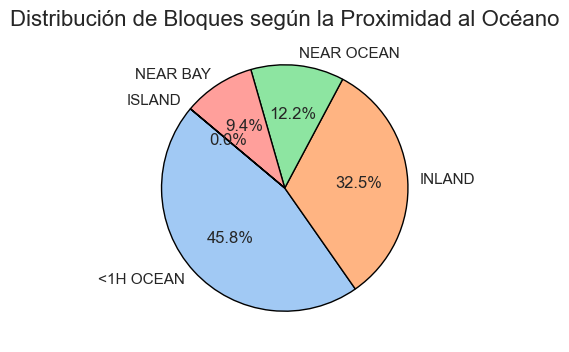

In [29]:
# Para saber que porcentaje representan las casas cerca de la bahia u oceano, hacemos un grafico de torta

# Contar la cantidad de bloques por categoría de proximidad al océano
ocean_proximity_counts = df2['ocean_proximity'].value_counts()

# Definir una paleta de colores agradables
colors = sns.color_palette('pastel')

# Crear el gráfico de pastel
plt.figure(figsize=(4, 4))
plt.pie(ocean_proximity_counts,labels=ocean_proximity_counts.index,colors=colors,autopct='%1.1f%%',startangle=140,wedgeprops={'edgecolor': 'black'})

# Añadir título
plt.title('Distribución de Bloques según la Proximidad al Océano', fontsize=16)

# Mostrar el gráfico
plt.show()

Quiero ver como es la distribucion de las casa que cuestan mas de  400.000 de acuerdo a su ocean_proximity

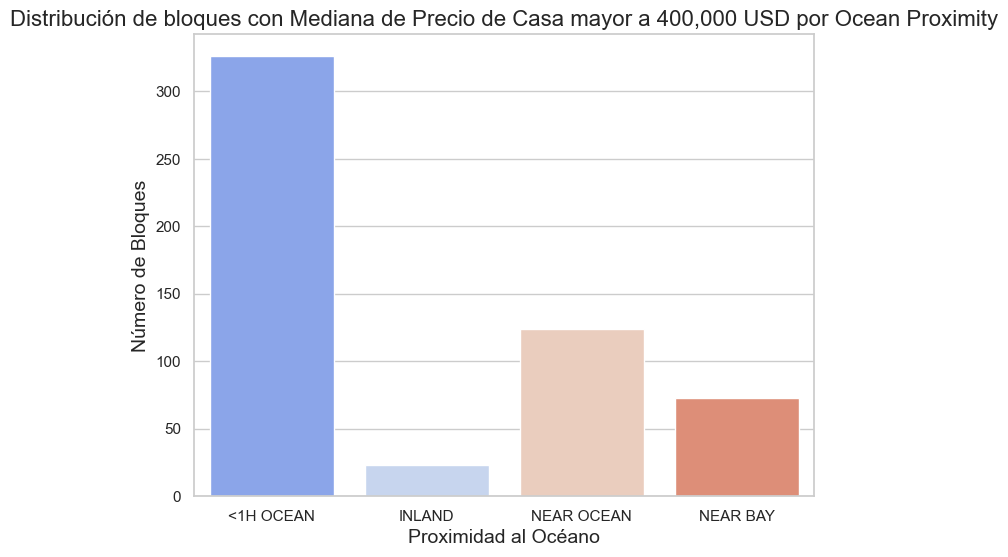

In [30]:
# Filtrar las casas con median_house_value mayor o igual a 400.000
filtered_houses = df2[(df2['median_house_value'] >= 400000)]

# Crear un gráfico de barras para mostrar la distribución de ocean_proximity
plt.figure(figsize=(8, 6))
sns.countplot(data=filtered_houses, x='ocean_proximity', hue='ocean_proximity', palette='coolwarm', dodge=False)

# Añadir títulos y etiquetas
plt.title('Distribución de bloques con Mediana de Precio de Casa mayor a 400,000 USD por Ocean Proximity', fontsize=16)
plt.xlabel('Proximidad al Océano', fontsize=14)
plt.ylabel('Número de Bloques', fontsize=14)

# Mostrar el gráfico
plt.show()


Observamos que la mayoria de casas que superan los 400.000 usd estan a menos de 1 hora del océano. En la siguiente gráfica podemos apreciar que las propiedades que estan mas adentro de tierra tienen mas variedad de precios y rango mas amplio.

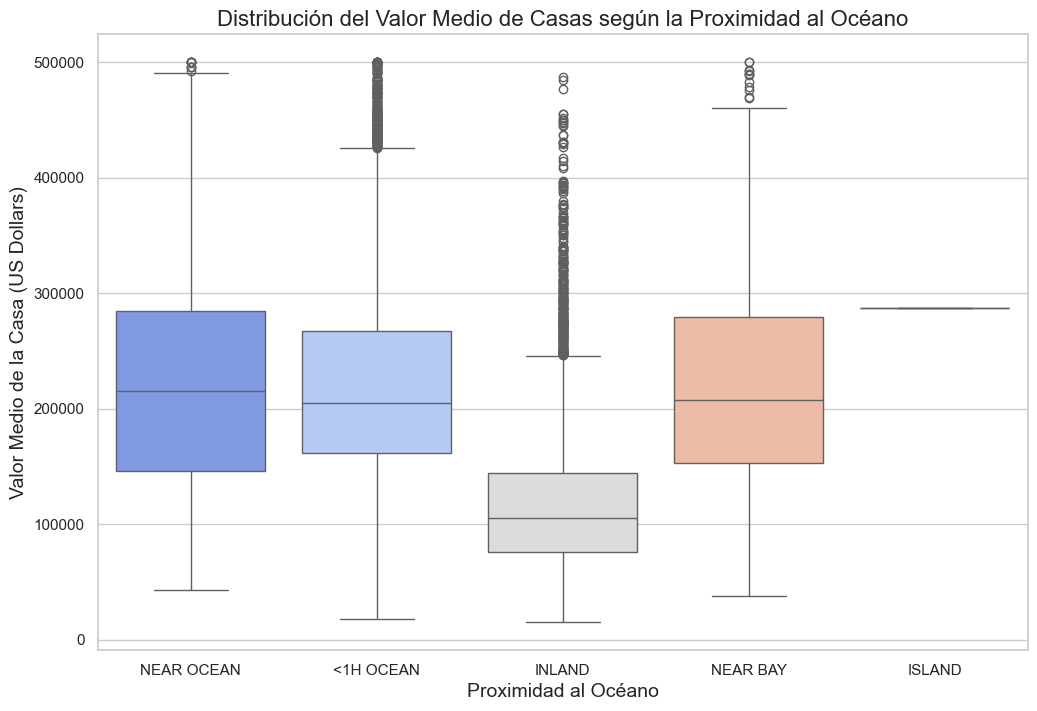

In [31]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear un gráfico de caja para 'median_house_value' vs 'ocean_proximity'
plt.figure(figsize=(12, 8))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=df2, hue='ocean_proximity', palette='coolwarm', dodge=False)

# Añadir títulos y etiquetas
plt.title('Distribución del Valor Medio de Casas según la Proximidad al Océano', fontsize=16)
plt.xlabel('Proximidad al Océano', fontsize=14)
plt.ylabel('Valor Medio de la Casa (US Dollars)', fontsize=14)

# Mostrar el gráfico
plt.show()

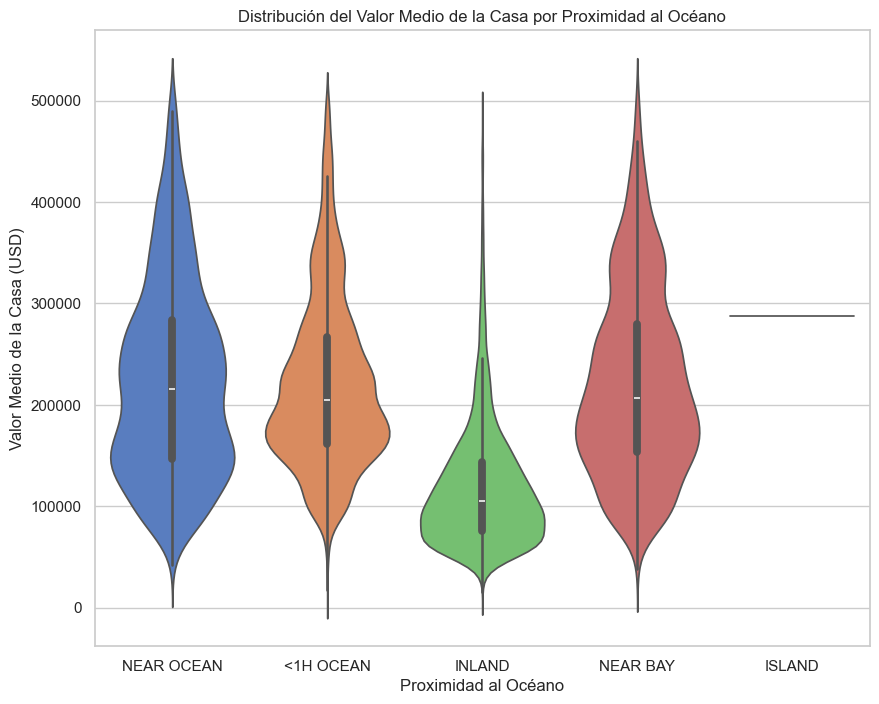

In [32]:
# Violin Plot
plt.figure(figsize=(10, 8))
sns.violinplot(x='ocean_proximity', y='median_house_value', hue='ocean_proximity', data=df2, palette='muted', dodge=False, legend=False)
plt.title('Distribución del Valor Medio de la Casa por Proximidad al Océano')
plt.xlabel('Proximidad al Océano')
plt.ylabel('Valor Medio de la Casa (USD)')
plt.show()


Se aprecia la concentración de valores de casas por proximidad al oceano.

Para INLAND estan entre 50.000 y 150.000

Para NEAR OCEAN estan entre 100.000 y 300.000

Para <1H OCEAN estan entre 130.000 y 250.000

Para NEAR BAY estan variadas pero a mayoria entre 150.000 y 350.000

Para ISLAND estan entre 350.000 y 500.000

### 🧬 Analisis bivariado 🧬

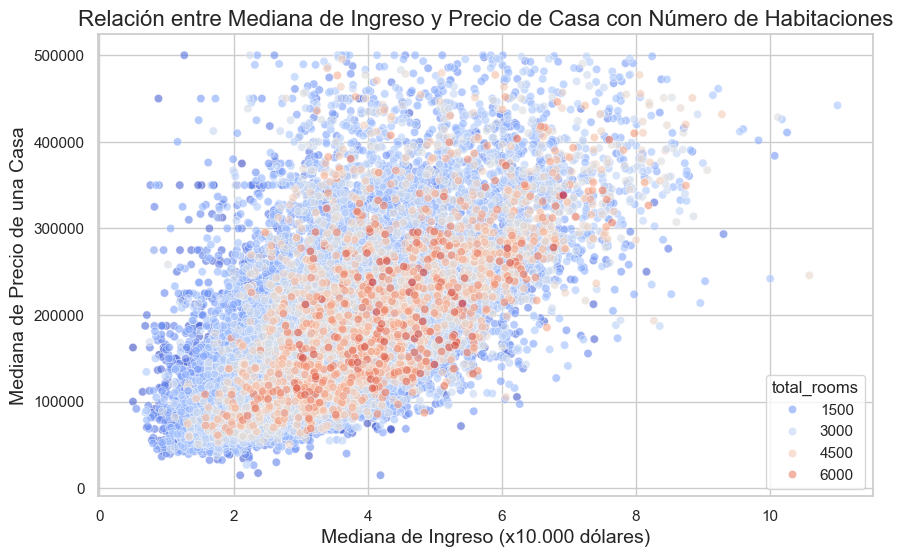

In [33]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_income', y='median_house_value', data=df2, hue='total_rooms', palette='coolwarm', alpha=0.6)

# Añadir títulos y etiquetas
plt.title('Relación entre Mediana de Ingreso y Precio de Casa con Número de Habitaciones', fontsize=16)
plt.xlabel('Mediana de Ingreso (x10.000 dólares)', fontsize=14)
plt.ylabel('Mediana de Precio de una Casa', fontsize=14)

# Mostrar el gráfico
plt.show()


Para explicar un poco el grafico anterior:

Tomare como ejemplo uno de los puntos rojo oscuro.
Quiere decir que en ese bloque/conjunto residencial, el cual cuenta con mas de 7500 habitaciones, la mediana de ingreso es de casi 50 mil USD y la mediana de precio para una casa alli esta alrededor de 200 mil USD.

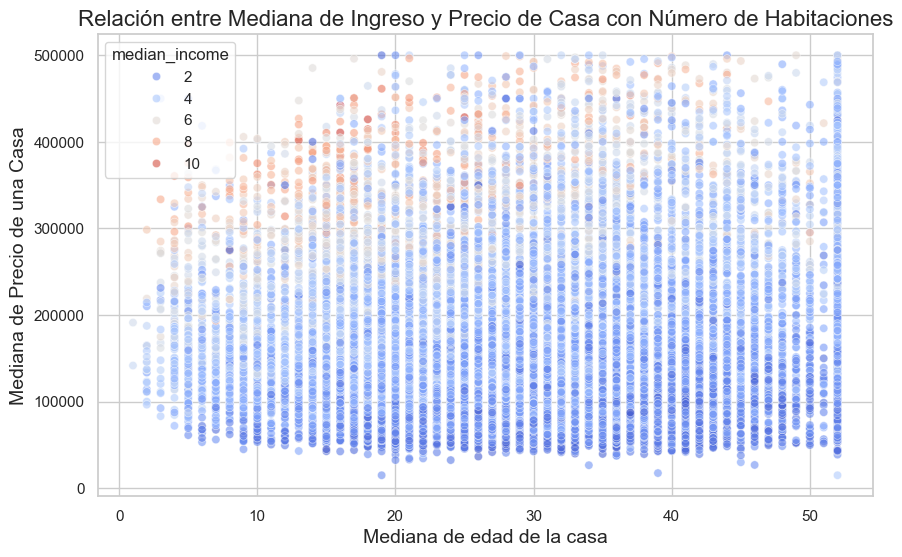

In [34]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='housing_median_age', y='median_house_value', data=df2, hue='median_income', palette='coolwarm', alpha=0.6)

# Añadir títulos y etiquetas
plt.title('Relación entre Mediana de Ingreso y Precio de Casa con Número de Habitaciones', fontsize=16)
plt.xlabel('Mediana de edad de la casa', fontsize=14)
plt.ylabel('Mediana de Precio de una Casa', fontsize=14)

# Mostrar el gráfico
plt.show()

######
De esta grafica poder decir que la gente con mayor poder adquisitivo eligen vivir en casas con una vida menor a 30 años.

Tambien se aprecia que de las casas que valen 500.000, el poder adquisitivo disminuye a medida que la casa es mas vieja, lo que respalda el escenario descrito anteriormente.

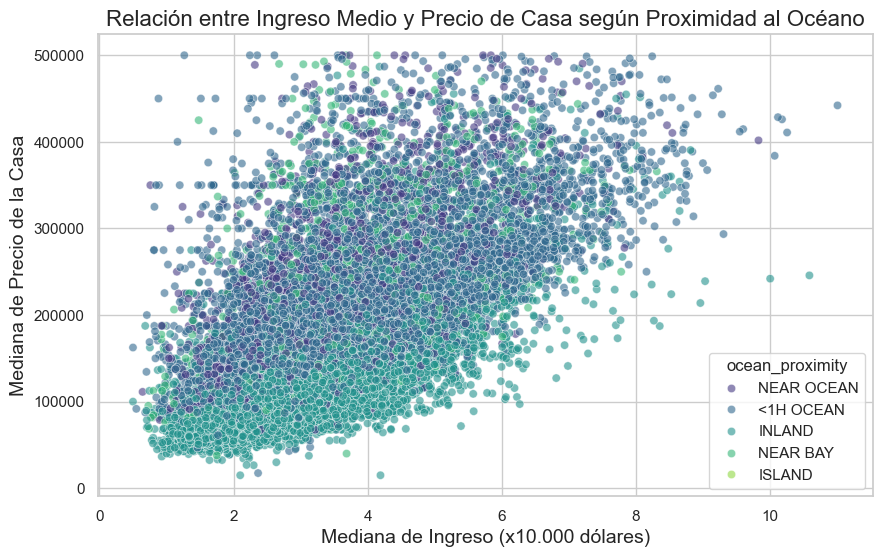

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_income', y='median_house_value', data=df2, hue='ocean_proximity', palette='viridis', alpha=0.6)

# Añadir títulos y etiquetas
plt.title('Relación entre Ingreso Medio y Precio de Casa según Proximidad al Océano', fontsize=16)
plt.xlabel('Mediana de Ingreso (x10.000 dólares)', fontsize=14)
plt.ylabel('Mediana de Precio de la Casa', fontsize=14)

# Mostrar el gráfico
plt.show()


Se observa que las casas con mayor mediana de valor estan muy cercanas a la bahia o al oceano.

Se observa que la mayoria de casas que estan adentro en tierra firme son habitadas por familias con mediana de ingresos menor a 60 mil USD, y el valor de la casa es proporcional a el.


### ⚗️ Matriz de correlación - Coeficiente de Pearson 🧪



median_house_value            1.000000
median_income                 0.630302
ocean_proximity_encoded       0.391066
avg_rooms_per_household       0.231172
total_rooms                   0.167874
housing_median_age            0.094845
households                    0.091067
total_bedrooms                0.072445
population                   -0.036795
avg_bedrooms_per_household   -0.123452
Name: median_house_value, dtype: float64




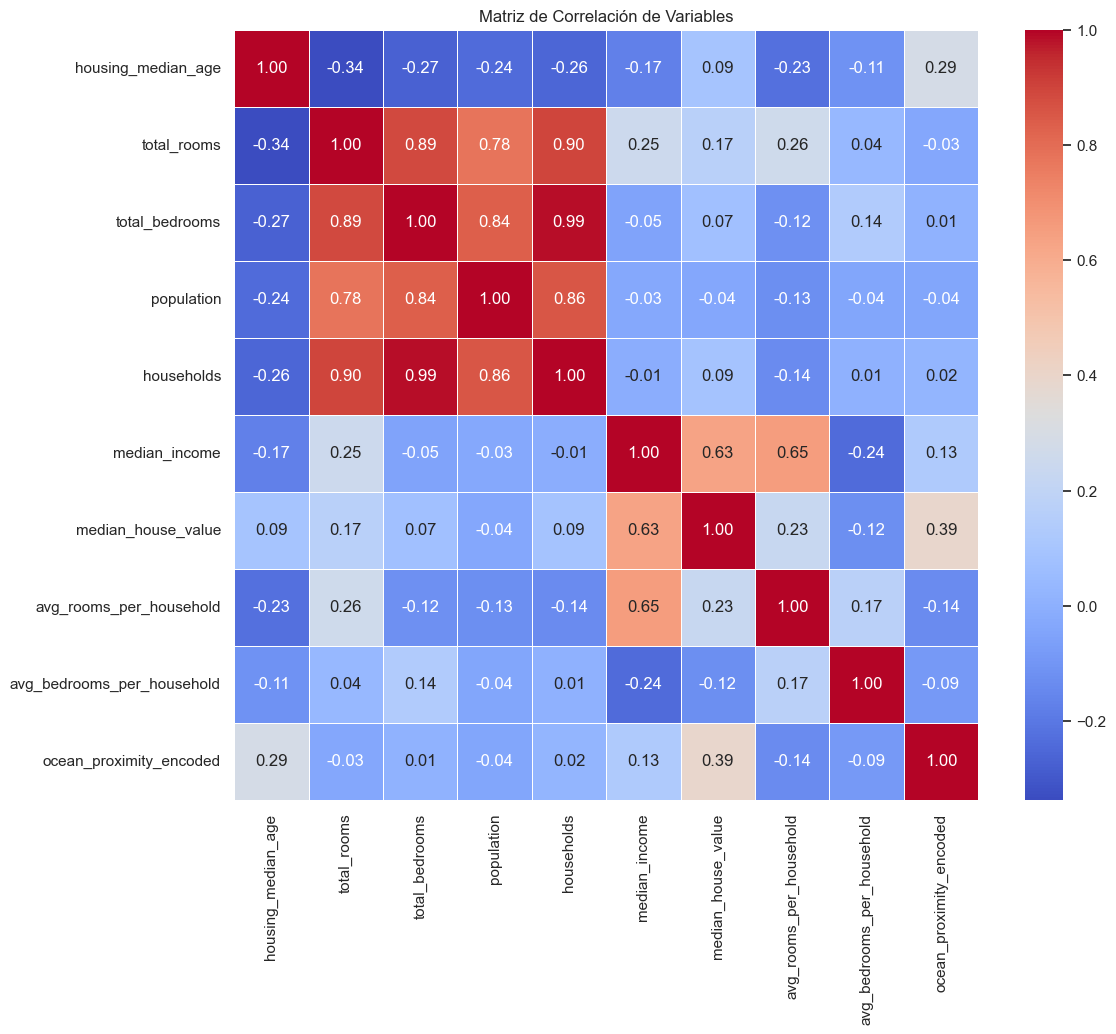

In [36]:
# Realizar ordinal encoding en la columna 'ocean_proximity'
encoder = OrdinalEncoder(categories=[["INLAND", "<1H OCEAN", "NEAR OCEAN", "NEAR BAY", "ISLAND"]])
df2['ocean_proximity_encoded'] = encoder.fit_transform(df2[['ocean_proximity']])

df_encoded = df2.drop(columns=['longitude', 'latitude', 'ocean_proximity'])

# Calcular la tabla de correlación con las variables codificadas
correlation_matrix = df_encoded.corr()

# Mostrar la tabla de correlación con respecto a 'median_house_value'
print("\n")
print(correlation_matrix['median_house_value'].sort_values(ascending=False))

# Visualizar la matriz de correlación completa como un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables')
print("\n")
plt.show()


Se observa que las variables mas influyentes en el precio son los ingresos, con 0.65, que me atrevo a decir que es obvio ya que mientras mas cara la propiedad quiere decir que el poder adquisitivo de la familia es mas alto; y la cercanía al oceano en segundo lugar. Tiene una correlación de 0.39 (moderada) lo que me da a entender que todas las casas cerca del oceano son costosas pero no todas las casas costosas estan cerca del oceano.

Tambien se observa que algunas dimensiones pueden llegar a ser redundantes entre si, especialmente las dimensiones que se usaron para crear las ultimas columnas del dataframe. Mas adelante realizaré una reducción de dimensionalidad (PCA).

### 🗺️ Mapa de calor 🗺️

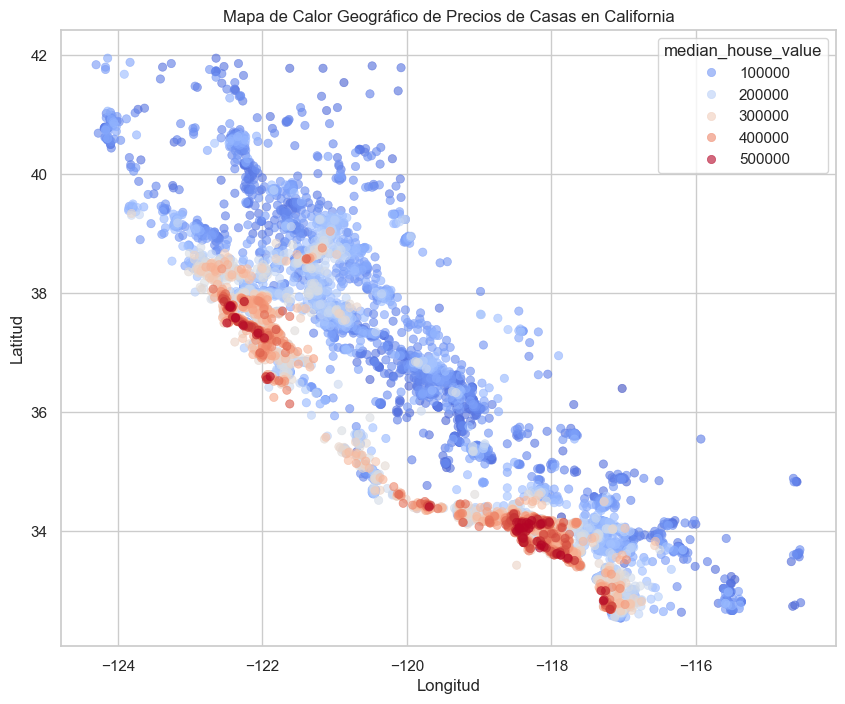

In [37]:

# Ordenar el DataFrame por 'median_house_value' en orden ascendente
df_sorted = df2.sort_values(by='median_house_value', ascending=True)

# Mapa de Calor Geográfico
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_sorted, x='longitude', y='latitude', 
                          hue='median_house_value', palette='coolwarm', 
                          edgecolor=None, alpha=0.6)

plt.title('Mapa de Calor Geográfico de Precios de Casas en California')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Mostrar el gráfico
plt.show()



##### Se observa que la mayoria de casas mas costosas estan cerca de la linea costera, y estan agrupadas en dos zonas.

### 📊 Analisis multivarido 📊

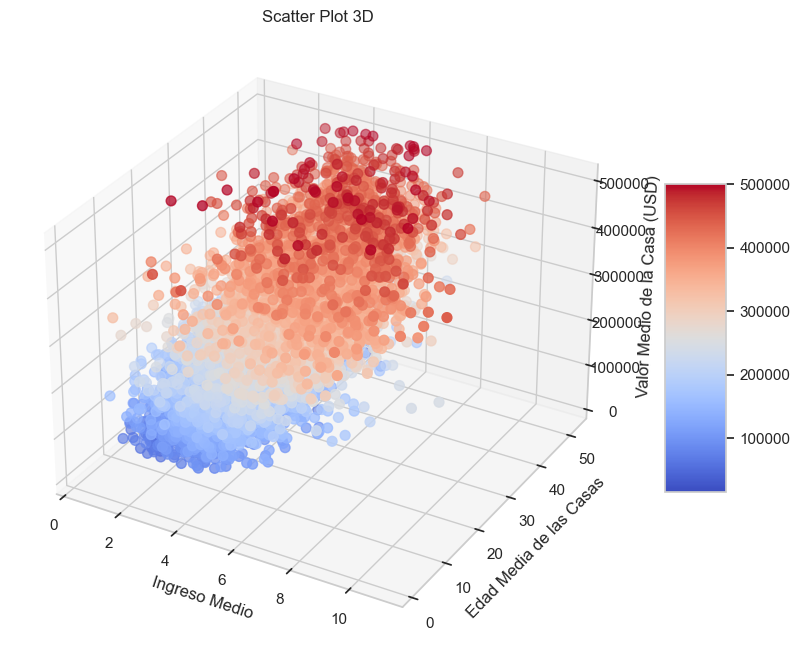

In [38]:
# Scatter Plot 3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df2['median_income'], df2['housing_median_age'], df2['median_house_value'], c=df2['median_house_value'], cmap='coolwarm', s=50)
ax.set_xlabel('Ingreso Medio')
ax.set_ylabel('Edad Media de las Casas')
ax.set_zlabel('Valor Medio de la Casa (USD)')
plt.title('Scatter Plot 3D')
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
plt.show()


Aca observamos que la edad media no afecta mucho la variacion de precios.

## 🧚🏻‍♀️🧚🏻‍♀️ Modelos de predicción 🧚🏻‍♀️🧚🏻‍♀️

### 📈 Reduccion de dimensionalidad 📉

In [39]:
df2.sample(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14257    -122.49     38.30                  14         2844           602.0   
10943    -118.46     34.25                  32         2217           422.0   
8789     -117.88     33.71                  30         1739           359.0   
17208    -119.57     37.02                  16         4199           794.0   
12566    -118.36     34.08                  52         1902           488.0   
18784    -118.35     34.10                  26         3977          1050.0   
17355    -122.26     37.85                  52         3503           752.0   
1907     -122.53     39.09                  11         1264           271.0   
10493    -122.16     37.47                  44         2581           437.0   
1697     -122.01     36.91                  19          691           191.0   

       population  households  median_income  median_house_value  \
14257        1613         544         3.3571              193600   
10943        1064         427         3.6989              208600   
8789         1914         369         3.5551              185200   
17208        2140         722         3.3320              111800   
12566         848         478         2.9621              175000   
18784        1720         935         3.3580              364500   
17355        1504         734         3.2705              241800   
1907          370         177         1.3000               69700   
10493        1006         414         5.3970              341700   
1697          324         167         3.1312              388500   

       avg_rooms_per_household  avg_bedrooms_per_household ocean_proximity  \
14257                 5.227941                    1.106618       <1H OCEAN   
10943                 5.192037                    0.988290       <1H OCEAN   
8789                  4.712737                    0.972900       <1H OCEAN   
17208                 5.815789                    1.099723          INLAND   
12566                 3.979079                    1.020921       <1H OCEAN   
18784                 4.253476                    1.122995       <1H OCEAN   
17355                 4.772480                    1.024523        NEAR BAY   
1907                  7.141243                    1.531073          INLAND   
10493                 6.234300                    1.055556        NEAR BAY   
1697                  4.137725                    1.143713      NEAR OCEAN   

       ocean_proximity_encoded  
14257                      1.0  
10943                      1.0  
8789                       1.0  
17208                      0.0  
12566                      1.0  
18784                      1.0  
17355                      3.0  
1907                       0.0  
10493                      3.0  
1697                       2.0

In [40]:
df3 = df2.drop(columns=['ocean_proximity'])
df3.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
6     -122.37     37.60                  26           15             3.0   
12    -117.86     33.67                  16           20             5.0   
14    -120.85     37.75                  26           28             4.0   
21    -118.04     33.90                  36           15             5.0   
26    -118.05     34.02                  31           40             8.0   
31    -118.44     34.04                  49           32             7.0   
35    -119.04     35.32                  20           37            11.0   
37    -120.13     35.87                  26           48             8.0   
39    -121.29     37.33                  36           48            12.0   
44    -118.20     34.02                  26           36             9.0   

    population  households  median_income  median_house_value  \
6           11           3         5.0480              350000   
12          15           5         3.8750              450000   
14           9           5         1.6250               85000   
21          15           6         0.4999              162500   
26          25           7         2.1250              375000   
31          14           7         2.1875              225000   
35          34           8         1.2000               50000   
37          13           8         2.3750               71300   
39          27           8         4.0000               75000   
44          35           9         1.6250              175000   

    avg_rooms_per_household  avg_bedrooms_per_household  \
6                  5.000000                    1.000000   
12                 4.000000                    1.000000   
14                 5.600000                    0.800000   
21                 2.500000                    0.833333   
26                 5.714286                    1.142857   
31                 4.571429                    1.000000   
35                 4.625000                    1.375000   
37                 6.000000                    1.000000   
39                 6.000000                    1.500000   
44                 4.000000                    1.000000   

    ocean_proximity_encoded  
6                       2.0  
12                      1.0  
14                      0.0  
21                      1.0  
26                      1.0  
31                      1.0  
35                      0.0  
37                      0.0  
39                      0.0  
44                      1.0

In [41]:
# Escalamos los datos para que todas las columnas tegan la misma influencia
X_scaled = StandardScaler().fit_transform(df3.drop(columns=['median_house_value']))

modelo_pca = PCA(n_components=8)

modelo_pca.fit(X_scaled)


PCA(n_components=8)

In [42]:
modelo_pca.components_

array([[ 0.0905702 , -0.08957646, -0.20133256,  0.4797405 ,  0.49598508,
         0.46405723,  0.49852332,  0.03804072, -0.00212095,  0.0271477 ,
        -0.03198355],
       [-0.57449069,  0.58469548, -0.15453481,  0.17219541,  0.00952178,
        -0.05700104,  0.00125799,  0.27464534,  0.43084962,  0.09976738,
         0.0142486 ],
       [ 0.38181111, -0.35008219, -0.27130331,  0.080679  , -0.1442094 ,
        -0.09560804, -0.13489239,  0.55157218,  0.51402809, -0.06140408,
        -0.17660052],
       [-0.10936023, -0.10075175,  0.36678929,  0.07081425, -0.00153758,
         0.05433292,  0.07250669,  0.38544906, -0.04014361, -0.53982129,
         0.62332914],
       [ 0.0777266 , -0.17963197,  0.25676397,  0.04371761,  0.09399548,
        -0.08601527, -0.00754333,  0.01256165,  0.20740497,  0.76245031,
         0.50304692],
       [ 0.05792777,  0.05637601,  0.8097696 ,  0.14793772,  0.03022928,
         0.09166258,  0.03907043,  0.00643393,  0.2590693 , -0.01577759,
        -0.487

In [43]:
modelo_pca.explained_variance_ratio_

array([0.34321362, 0.18313076, 0.16253036, 0.12515408, 0.08598726,
       0.05802991, 0.019005  , 0.01749549])

In [44]:
df4=df3.drop(columns=['median_house_value'])
lista_componentes = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
componentes = pd.DataFrame(data=modelo_pca.components_, columns = df4.columns, index=lista_componentes)
componentes

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
PC1   0.090570 -0.089576           -0.201333     0.479741        0.495985   
PC2  -0.574491  0.584695           -0.154535     0.172195        0.009522   
PC3   0.381811 -0.350082           -0.271303     0.080679       -0.144209   
PC4  -0.109360 -0.100752            0.366789     0.070814       -0.001538   
PC5   0.077727 -0.179632            0.256764     0.043718        0.093995   
PC6   0.057928  0.056376            0.809770     0.147938        0.030229   
PC7  -0.079761  0.003675            0.070232    -0.077071        0.241303   
PC8  -0.119837  0.001925            0.020401    -0.329258       -0.198840   

     population  households  median_income  avg_rooms_per_household  \
PC1    0.464057    0.498523       0.038041                -0.002121   
PC2   -0.057001    0.001258       0.274645                 0.430850   
PC3   -0.095608   -0.134892       0.551572                 0.514028   
PC4    0.054333    0.072507       0.385449                -0.040144   
PC5   -0.086015   -0.007543       0.012562                 0.207405   
PC6    0.091663    0.039070       0.006434                 0.259069   
PC7   -0.422430    0.197905       0.575427                -0.523873   
PC8    0.757113   -0.204814       0.355724                -0.195488   

     avg_bedrooms_per_household  ocean_proximity_encoded  
PC1                    0.027148                -0.031984  
PC2                    0.099767                 0.014249  
PC3                   -0.061404                -0.176601  
PC4                   -0.539821                 0.623329  
PC5                    0.762450                 0.503047  
PC6                   -0.015778                -0.487447  
PC7                    0.206953                -0.241914  
PC8                    0.228070                -0.073017

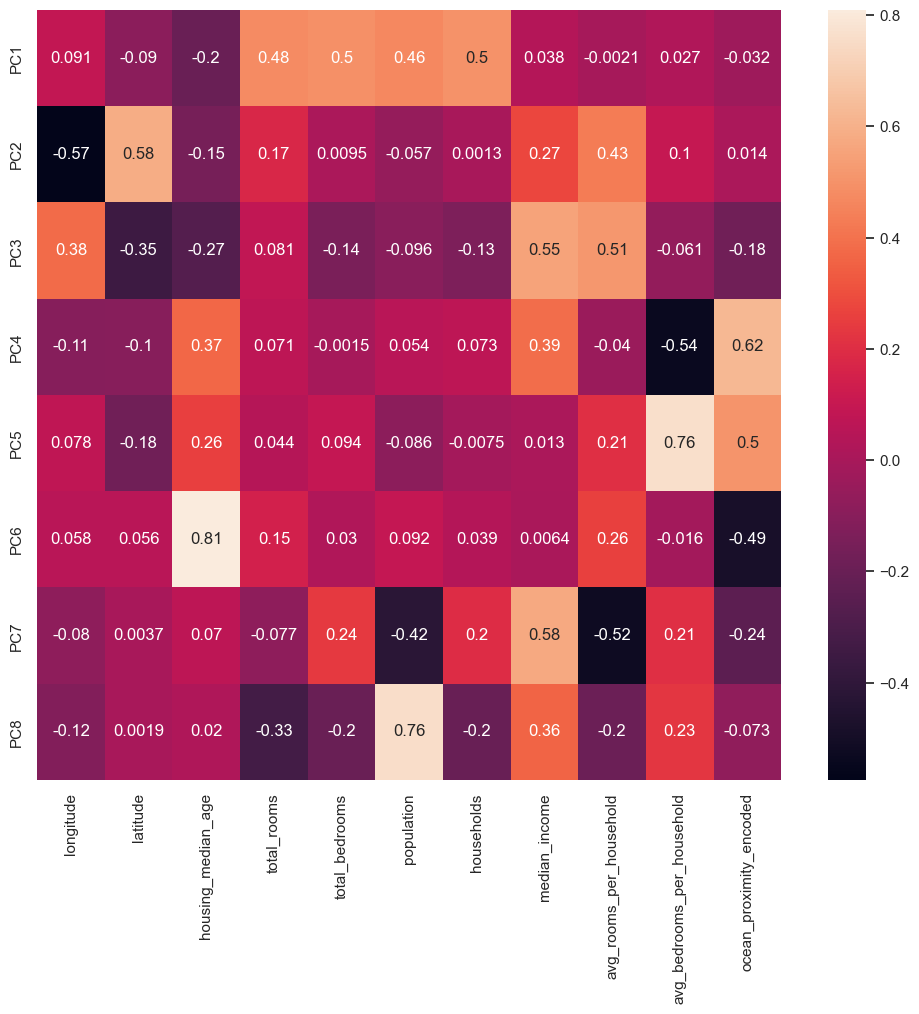

In [45]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(componentes, annot=True)

In [46]:
proyecciones = pd.DataFrame(modelo_pca.transform(df4), index=df4.index, columns=lista_componentes)
proyecciones

c:\Users\ingdj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


PC1          PC2         PC3         PC4         PC5  \
6        -4.256929    93.924252  -62.678139   23.455316   -6.751770   
12        4.750334    90.468069  -58.388977   19.368187   -8.940664   
14        2.595896    94.773259  -62.538382   21.747199   -6.918441   
21       -1.343136    85.165684  -67.124995   25.268176   -4.567402   
26       18.335841    91.641045  -62.791345   26.135085   -4.443255   
...            ...          ...         ...         ...         ...   
20207  6362.393873  1063.957351 -300.284906  783.852237  149.417215   
20213  6262.343319  1063.319060 -280.109716  775.828579  145.616207   
20234  5959.393588   917.764964 -368.815563  724.487437  108.618178   
20250  6079.487230  1111.551314 -236.573093  750.036910  211.511880   
20275  5807.066223  1003.845111 -295.678489  709.289435  187.405878   

               PC6          PC7         PC8  
6        19.857534     7.247910   18.345947  
12       13.265303     5.065573   18.020010  
14       22.913742     5.765695   10.526525  
21       28.354927     5.877868   18.946125  
26       29.895386    -0.386021   17.404240  
...            ...          ...         ...  
20207  1422.387345 -1185.988939 -320.858502  
20213  1402.327011 -1164.760706 -363.297911  
20234  1293.854326 -1120.940776  -40.728047  
20250  1361.260062  -875.185749 -884.639249  
20275  1272.864906  -811.591532 -693.700581  

[17527 rows x 8 columns]

In [47]:
proyecciones.drop(columns = ['PC6', 'PC7', 'PC8'], inplace=True)

In [48]:
proyecciones

PC1          PC2         PC3         PC4         PC5
6        -4.256929    93.924252  -62.678139   23.455316   -6.751770
12        4.750334    90.468069  -58.388977   19.368187   -8.940664
14        2.595896    94.773259  -62.538382   21.747199   -6.918441
21       -1.343136    85.165684  -67.124995   25.268176   -4.567402
26       18.335841    91.641045  -62.791345   26.135085   -4.443255
...            ...          ...         ...         ...         ...
20207  6362.393873  1063.957351 -300.284906  783.852237  149.417215
20213  6262.343319  1063.319060 -280.109716  775.828579  145.616207
20234  5959.393588   917.764964 -368.815563  724.487437  108.618178
20250  6079.487230  1111.551314 -236.573093  750.036910  211.511880
20275  5807.066223  1003.845111 -295.678489  709.289435  187.405878

[17527 rows x 5 columns]

In [49]:
proyecciones['median_house_value'] = df3['median_house_value']
proyecciones['ocean_proximity'] = df2['ocean_proximity']
proyecciones

PC1          PC2         PC3         PC4         PC5  \
6        -4.256929    93.924252  -62.678139   23.455316   -6.751770   
12        4.750334    90.468069  -58.388977   19.368187   -8.940664   
14        2.595896    94.773259  -62.538382   21.747199   -6.918441   
21       -1.343136    85.165684  -67.124995   25.268176   -4.567402   
26       18.335841    91.641045  -62.791345   26.135085   -4.443255   
...            ...          ...         ...         ...         ...   
20207  6362.393873  1063.957351 -300.284906  783.852237  149.417215   
20213  6262.343319  1063.319060 -280.109716  775.828579  145.616207   
20234  5959.393588   917.764964 -368.815563  724.487437  108.618178   
20250  6079.487230  1111.551314 -236.573093  750.036910  211.511880   
20275  5807.066223  1003.845111 -295.678489  709.289435  187.405878   

       median_house_value ocean_proximity  
6                  350000      NEAR OCEAN  
12                 450000       <1H OCEAN  
14                  85000          INLAND  
21                 162500       <1H OCEAN  
26                 375000       <1H OCEAN  
...                   ...             ...  
20207              179800       <1H OCEAN  
20213              271100       <1H OCEAN  
20234              243100       <1H OCEAN  
20250              273700       <1H OCEAN  
20275              246900       <1H OCEAN  

[17527 rows x 7 columns]

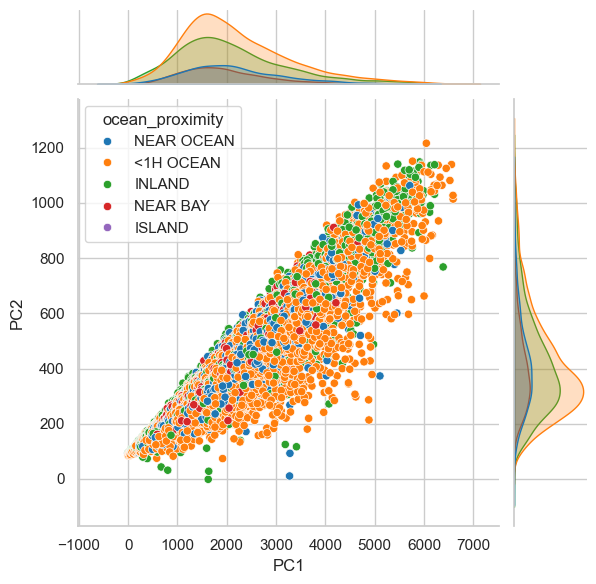

In [50]:
g = sns.jointplot(x='PC1', y='PC2', data=proyecciones, hue='ocean_proximity', palette= 'tab10')
g.fig.set_figwidth(6)

###  🎌 Modelo KNeighbors Regression 🎌

In [51]:

proyecciones=proyecciones.drop(columns=['ocean_proximity'])
proyecciones.head()


PC1        PC2        PC3        PC4       PC5  median_house_value
6   -4.256929  93.924252 -62.678139  23.455316 -6.751770              350000
12   4.750334  90.468069 -58.388977  19.368187 -8.940664              450000
14   2.595896  94.773259 -62.538382  21.747199 -6.918441               85000
21  -1.343136  85.165684 -67.124995  25.268176 -4.567402              162500
26  18.335841  91.641045 -62.791345  26.135085 -4.443255              375000

In [52]:
proyecciones_features = proyecciones[['PC1', 'PC2','PC3','PC4','PC5']]
proyecciones_features

PC1          PC2         PC3         PC4         PC5
6        -4.256929    93.924252  -62.678139   23.455316   -6.751770
12        4.750334    90.468069  -58.388977   19.368187   -8.940664
14        2.595896    94.773259  -62.538382   21.747199   -6.918441
21       -1.343136    85.165684  -67.124995   25.268176   -4.567402
26       18.335841    91.641045  -62.791345   26.135085   -4.443255
...            ...          ...         ...         ...         ...
20207  6362.393873  1063.957351 -300.284906  783.852237  149.417215
20213  6262.343319  1063.319060 -280.109716  775.828579  145.616207
20234  5959.393588   917.764964 -368.815563  724.487437  108.618178
20250  6079.487230  1111.551314 -236.573093  750.036910  211.511880
20275  5807.066223  1003.845111 -295.678489  709.289435  187.405878

[17527 rows x 5 columns]

In [53]:
proyecciones_target = proyecciones [['median_house_value']]
proyecciones_target

median_house_value
6                  350000
12                 450000
14                  85000
21                 162500
26                 375000
...                   ...
20207              179800
20213              271100
20234              243100
20250              273700
20275              246900

[17527 rows x 1 columns]

In [54]:
# Separamos en entrenamiento/test en razon 80/20
X_train, X_test, y_train, y_test = train_test_split(proyecciones_features, proyecciones_target, test_size = 0.2, random_state = 2)

# Definimos el modelo
modelo = KNeighborsRegressor(n_neighbors=5)
modelo.fit(X_train, y_train)


KNeighborsRegressor()

In [55]:
preds_train = modelo.predict(X_train)
preds_test = modelo.predict(X_test)

 

In [56]:
y_test

median_house_value
10496              182700
7573               177100
11951              350000
11125              150700
9463               103800
...                   ...
4406               178400
9742                54600
2435                83300
4156               250000
10696              310000

[3506 rows x 1 columns]

In [57]:
preds_test

array([[178840.],
       [215920.],
       [300300.],
       ...,
       [ 74960.],
       [137860.],
       [155720.]])

In [58]:
# Calcula las métricas
mse_train = mean_squared_error(y_train, preds_train)
r2_train = r2_score(y_train, preds_train)

print(f"MSE en entrenamiento: {mse_train:.2f}")
print(f"R2 en entrenamiento: {r2_train:.2f}")

MSE en entrenamiento: 5035677140.67
R2 en entrenamiento: 0.42


In [59]:
# Calcula las métricas
mse_test = mean_squared_error(y_test, preds_test)
r2_test = r2_score(y_test, preds_test)

print(f"MSE en testeo: {mse_test:.2f}")
print(f"R2 en testeo: {r2_test:.2f}")

MSE en testeo: 7953636075.17
R2 en testeo: 0.12


Vemos que la varianza esta mas cerca de 0 que de 1, asi que he llegado a la conclusion de que este modelo no es bueno para este proyecto.
Intentaré otros modelos.

### 📏 Modelo Linear Regression 📏

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17527 entries, 6 to 20275
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   17527 non-null  float64
 1   latitude                    17527 non-null  float64
 2   housing_median_age          17527 non-null  int64  
 3   total_rooms                 17527 non-null  int64  
 4   total_bedrooms              17527 non-null  float64
 5   population                  17527 non-null  int64  
 6   households                  17527 non-null  int64  
 7   median_income               17527 non-null  float64
 8   median_house_value          17527 non-null  int64  
 9   avg_rooms_per_household     17527 non-null  float64
 10  avg_bedrooms_per_household  17527 non-null  float64
 11  ocean_proximity             17527 non-null  object 
 12  ocean_proximity_encoded     17527 non-null  float64
dtypes: float64(7), int64(5), object(1)
m

In [61]:
df3 = df2.drop(columns=['ocean_proximity'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17527 entries, 6 to 20275
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   17527 non-null  float64
 1   latitude                    17527 non-null  float64
 2   housing_median_age          17527 non-null  int64  
 3   total_rooms                 17527 non-null  int64  
 4   total_bedrooms              17527 non-null  float64
 5   population                  17527 non-null  int64  
 6   households                  17527 non-null  int64  
 7   median_income               17527 non-null  float64
 8   median_house_value          17527 non-null  int64  
 9   avg_rooms_per_household     17527 non-null  float64
 10  avg_bedrooms_per_household  17527 non-null  float64
 11  ocean_proximity_encoded     17527 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 2.2 MB


In [62]:
# Definir las variables independientes (X) y la variable dependiente (y)
features = ['housing_median_age', 'population', 'total_bedrooms', 'households', 
            'avg_bedrooms_per_household', 'total_rooms', 'avg_rooms_per_household', 
            'median_income', 'ocean_proximity_encoded','latitude', 'longitude']

y = df3['median_house_value']

# Defino las variables que van a guardar los valores de la mejor combinacion de features
best_r2 = -float('inf')
best_combination = None
best_Y_test = None
best_Y_pred = None

# Crear una lista para guardar los resultados
results = []

# Voy a probar cada una de las combinaciones de features y me voy a quedar con la que mejor resultados me de
for r in range(1, len(features) + 1):
    for combo in itertools.combinations(features, r):
        # Seleccionar la combinación de características
        X = df3[list(combo)]
        
        # Dividir los datos en conjunto de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Crear el modelo de regresión lineal
        model_lr = LinearRegression()
        
        # Entrenar el modelo
        model_lr.fit(X_train, y_train)
        
        # Hacer predicciones
        y_pred = model_lr.predict(X_test)
        
        # Calcular el error cuadrático medio (MSE)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        
        # Calcular el coeficiente de determinación (R²)
        r2 = r2_score(y_test, y_pred)

        # Si el nuevo R² es mejor, actualizar los valores
        if r2 > best_r2:
            best_r2 = r2
            best_combination = combo
            best_model_coef = model_lr.coef_
            best_model_intercept = model_lr.intercept_
            best_X_train = X_train
            best_X_test = X_test
            best_y_train = y_train
            best_y_test = y_test
            best_y_pred = y_pred
        
        # Guardar el resultado
        results.append({'features': combo, 'mse': mse, 'rmse': rmse, 'r2': r2})


# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar las mejores combinaciones de características (menor RMSE)
print(results_df.sort_values(by='rmse').head(10))

# Encontrar la fila con el menor RMSE
best_rmse_result = results_df.loc[results_df['rmse'].idxmin()]

# Mostrar las características y el RMSE
print(f"\n\nMejor combinación de características (menor RMSE): {best_rmse_result['features']}")
print(f"RMSE: {best_rmse_result['rmse']}")
print(f"R²: {best_rmse_result['r2']}\n")
print(f"\nCoeficientes del modelo: {best_model_coef}")
print(f"\nIntercepto del modelo: {best_model_intercept}\n")


                                               features           mse  \
2043  (housing_median_age, population, households, a...  3.337622e+09   
2046  (housing_median_age, population, total_bedroom...  3.339285e+09   
2042  (housing_median_age, population, total_bedroom...  3.340927e+09   
2010  (housing_median_age, population, households, a...  3.345236e+09   
2037  (housing_median_age, population, total_bedroom...  3.347058e+09   
2013  (housing_median_age, population, households, a...  3.347370e+09   
2006  (housing_median_age, population, total_bedroom...  3.347778e+09   
2003  (housing_median_age, population, total_bedroom...  3.348366e+09   
2040  (housing_median_age, population, total_bedroom...  3.349577e+09   
2012  (housing_median_age, population, households, a...  3.350528e+09   

              rmse        r2  
2043  57772.156320  0.622489  
2046  57786.545716  0.622301  
2042  57800.754927  0.622115  
2010  57838.014983  0.621628  
2037  57853.767434  0.621422  
2013  5785

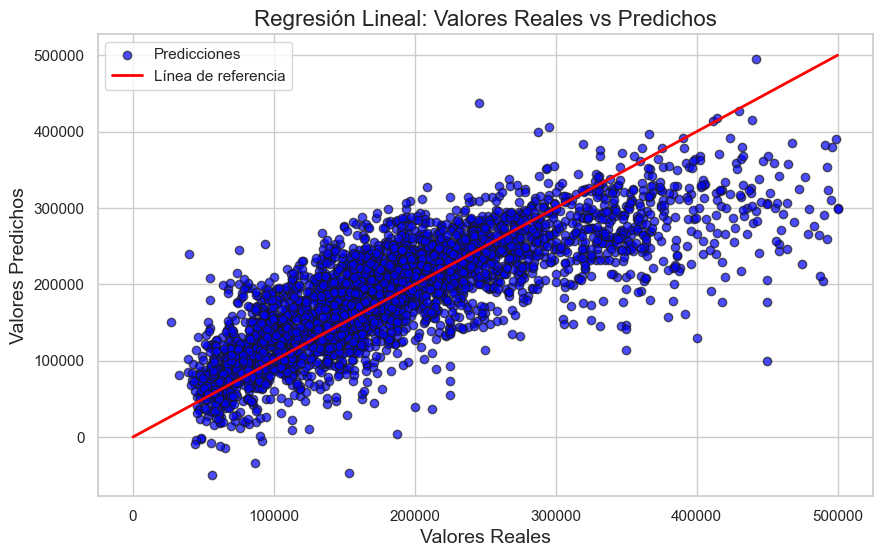

R² del mejor modelo: 0.6224888627044908


In [63]:
# Crear el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(best_y_test, best_y_pred, color='blue', edgecolors='k', alpha=0.7, label='Predicciones')

# Añadir una línea de referencia (y=x)
plt.plot([0, 500000], [0, 500000], color='red', lw=2, label='Línea de referencia')

# Añadir títulos y etiquetas
plt.title('Regresión Lineal: Valores Reales vs Predichos', fontsize=16)
plt.xlabel('Valores Reales', fontsize=14)
plt.ylabel('Valores Predichos', fontsize=14)

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# Mostrar el R²
r2_rl = r2_score(best_y_test, best_y_pred)
print(f"R² del mejor modelo: {r2_rl}")

En la grafica podemos ver que la regresion lineal es buena prediciendo valores menores a 300.000. Despues el comportamiento pareciera tener otra inclinacion o pendiente.

### 💥 Modelo XGBoost 💥

#### Probamos XGBoost colocando parametros manualmente

In [112]:
# Definir las variables independientes (X) y la variable dependiente (y)
features = ['housing_median_age', 'population', 'total_bedrooms', 'households', 
            'avg_bedrooms_per_household', 'total_rooms', 'avg_rooms_per_household', 
            'median_income', 'ocean_proximity_encoded','latitude', 'longitude']

y = df3['median_house_value']
X = df3[features]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el modelo
model_xgb = XGBRegressor(n_estimators = 2000, max_depth = 7, learning_rate = 0.015, subsample = 0.70)

# Lo entrenamos
model_xgb.fit(X_train, y_train)

# Predicciones
y_pred = model_xgb.predict(X_test)

# Metrica r2
r2_xgb = r2_score(y_test, y_pred)
r2_xgb

0.8389371633529663

In [113]:
# Pruebo con cv=5
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')
print(f"R2 promedio en CV: {scores.mean():.2f} ± {scores.std():.2f}")


R2 promedio en CV: 0.83 ± 0.00


#### Probamos XGBoost + Optimizacion de Hiperparametros y Cross-Validation

In [126]:
# Inicialización del modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [2000],
    'max_depth': [7],
    'learning_rate': [0.015],
    'subsample': [0.7]
}

# Configuración del Halving Grid Search
search = HalvingGridSearchCV(
    xgb_model,
    param_grid,
    factor=2,  # Cada iteración reduce a la mitad las configuraciones evaluadas
    scoring='r2',
    cv=3,  # Cross-validation de 3 folds
    n_jobs=-1,
    verbose=1
)

# Ejecución del proceso de búsqueda
search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", search.best_params_)
best_model = search.best_estimator_

# Evaluación en el conjunto de prueba
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MSE en prueba: {mse:.2f}")
print(f"R2 en prueba: {r2:.2f}")

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 14021
max_resources_: 14021
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1
n_resources: 14021
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejores hiperparámetros: {'learning_rate': 0.015, 'max_depth': 7, 'n_estimators': 2000, 'subsample': 0.7}
MSE en prueba: 1431975910.84
R2 en prueba: 0.84


Se puede observar que claramente el XGBoost es el modelo que mejor me ha dado resultado. Este será mi modelo a usar como solucion a mi problematica.

### 🧙🏻🪄✨ Lazy Prediction ✨🪄🧙🏻

Por ultimo le voy a dar un vistazo al Lazy Predictor para ver si me puede aportar algo mas a mi analisis.

In [125]:
# Definimos el modelo
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# Entrenamos el modelo
modelos, predicciones = lazy_reg.fit(X_train, X_test, y_train, y_test)

modelos

 43%|████▎     | 18/42 [06:04<08:12, 20.53s/it]c:\Users\ingdj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.896e+12, tolerance: 1.225e+10
  model = cd_fast.enet_coordinate_descent(
 60%|█████▉    | 25/42 [06:10<00:46,  2.74s/it]c:\Users\ingdj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 42/42 [07:45<00:00, 11.08s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
XGBRegressor                                 0.82       0.82  39984.19   
LGBMRegressor                                0.82       0.82  40089.34   
HistGradientBoostingRegressor                0.82       0.82  40345.06   
RandomForestRegressor                        0.80       0.80  41640.41   
ExtraTreesRegressor                          0.78       0.78  43973.47   
BaggingRegressor                             0.78       0.78  44393.48   
GradientBoostingRegressor                    0.74       0.74  48046.99   
KNeighborsRegressor                          0.67       0.67  54017.84   
PoissonRegressor                             0.63       0.63  56948.80   
LassoLarsIC                                  0.62       0.62  57772.85   
LassoLarsCV                                  0.62       0.62  57773.66   
LassoCV                                      0.62       0.62  57776.99   
BayesianRidge                                0.62       0.62  57782.52   
RidgeCV                                      0.62       0.62  57784.42   
Ridge                                        0.62       0.62  57784.42   
Lasso                                        0.62       0.62  57785.16   
LassoLars                                    0.62       0.62  57785.61   
Lars                                         0.62       0.62  57786.55   
TransformedTargetRegressor                   0.62       0.62  57786.55   
LinearRegression                             0.62       0.62  57786.55   
SGDRegressor                                 0.62       0.62  57815.90   
LarsCV                                       0.62       0.62  57894.30   
HuberRegressor                               0.61       0.61  58380.04   
PassiveAggressiveRegressor                   0.61       0.61  58745.05   
DecisionTreeRegressor                        0.59       0.59  60250.89   
OrthogonalMatchingPursuitCV                  0.55       0.55  63141.88   
ElasticNet                                   0.50       0.50  66711.93   
ExtraTreeRegressor                           0.48       0.48  67918.94   
RANSACRegressor                              0.47       0.47  68462.77   
TweedieRegressor                             0.42       0.42  71423.91   
GammaRegressor                               0.42       0.42  71585.37   
AdaBoostRegressor                            0.41       0.41  72045.55   
OrthogonalMatchingPursuit                    0.39       0.39  73279.29   
ElasticNetCV                                 0.02       0.02  92944.03   
DummyRegressor                              -0.00      -0.00  94027.24   
NuSVR                                       -0.01      -0.01  94273.30   
SVR                                         -0.03      -0.03  95301.85   
QuantileRegressor                           -0.04      -0.03  95625.02   
MLPRegressor                                -1.92      -1.91 160418.37   
GaussianProcessRegressor                    -2.21      -2.20 168131.50   
KernelRidge                                 -3.45      -3.43 197978.73   
LinearSVR                                   -3.47      -3.46 198472.80   

                               Time Taken  
Model                                      
XGBRegressor                         0.94  
LGBMRegressor                        0.75  
HistGradientBoostingRegressor        1.58  
RandomForestRegressor               22.23  
ExtraTreesRegressor                  8.23  
BaggingRegressor                     2.52  
GradientBoostingRegressor            5.99  
KNeighborsRegressor                  0.50  
PoissonRegressor                     0.10  
LassoLarsIC                          0.12  
LassoLarsCV                          0.12  
LassoCV                              1.99  
BayesianRidge                        0.12  
RidgeCV                              0.06  
Ridge                                0.04  
Lasso                     

Se verfica que el modelo que mejor resultado le da es el XGBoost, lo cual es lo que habiamos encontrado anteriormente.

## 🤓 Conclusión del Proyecto 🤓

En este proyecto, se exploraron distintos enfoques para construir un modelo de predicción del precio de propiedades en California. A partir de un análisis exhaustivo del dataset, se observaron patrones clave que influyen en los precios de las viviendas, como el ingreso medio de los hogares y el número promedio de habitaciones por hogar.

Se probaron varios algoritmos de Machine Learning, incluidos KNeighbors Regression combinado con reducción de dimensionalidad mediante PCA, Linear Regression y XGBoost. Para evaluar el rendimiento de estos modelos, se utilizó la métrica R², la cual mostró resultados variados:

KNN + PCA: r² ≈ 0.12
Regresión Lineal: r² ≈ 0.62
XGBoost: r² ≈ 0.84

El modelo XGBoost demostró ser el más efectivo, superando a los demás tanto en precisión como en estabilidad. Esto se confirmó mediante técnicas de búsqueda de hiperparámetros como Halving Grid Search, que identificaron configuraciones óptimas del modelo, incluyendo learning_rate=0.015, max_depth=7, n_estimators=2000, y subsample=0.7.

Lazy Predict corroboró los resultados, señalando también a XGBoost como la opción más eficiente para este conjunto de datos.

A pesar del éxito obtenido, una de las limitaciones del análisis fue la ausencia de un enfoque híbrido para manejar propiedades con valores superiores a 500,000, lo cual podría haber mejorado el rendimiento del modelo al tratar estos casos como una categoría especial.

Este proyecto demuestra que, al combinar técnicas avanzadas de selección de modelos, optimización de hiperparámetros y análisis exploratorio, es posible obtener resultados sólidos en la predicción de precios inmobiliarios. Sin embargo, futuras investigaciones podrían beneficiarse de una segmentación más granular de los datos y la inclusión de enfoques híbridos para capturar mejor el comportamiento de propiedades con valores atípicos.